In [1]:
%load_ext autoreload
%autoreload 2
from scipy import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from braincoder.utils.visualize import *
%matplotlib inline

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
tf.config.list_physical_devices('GPU')

    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2025-02-18 11:24:58.986305: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-18 11:24:58.986369: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-18 11:24:58.986385: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 11:24:58.995504: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
dm = io.loadmat('GazeCenterFS_vd.mat')['stim']

# braincoder convention is time by x by y
paradigm = np.rollaxis(dm, 2, 0)
aspect_ratio = paradigm.shape[2] / paradigm.shape[1]

x, y = np.meshgrid(np.linspace(-.75, .75, 3), np.linspace(-aspect_ratio *.75, aspect_ratio *.75, 3))
y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)

y_grid, x_grid = np.meshgrid(np.linspace(-aspect_ratio, aspect_ratio, paradigm.shape[2]), 
                              np.linspace(-1., 1., paradigm.shape[1]))

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)
n_vx = 10
bounds = {
    'x' : [-1, 1],
    'y' : [-.5, .5],
    'sd' : [0.01, 2],
    'baseline' : [-1,1],
    'amplitude' : [0, 5], 
}
parameters = pd.DataFrame({
    key:np.random.uniform(bounds[key][0], bounds[key][1], n_vx) for key in bounds
}).astype('float32')

idx_cols = sns.color_palette("hsv", n_vx)

In [3]:
aspect_ratio

0.5625

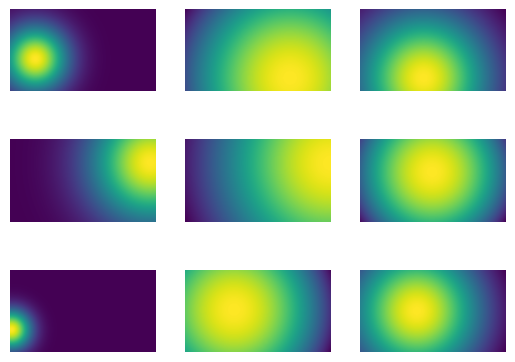

In [4]:
from braincoder.models import GaussianPRF2DWithHRF
from braincoder.hrf import SPMHRFModel
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
for i in np.arange(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(model.get_rf()[i].reshape((240, 135)).T)
    plt.axis("off")

## Predictions (no noise)

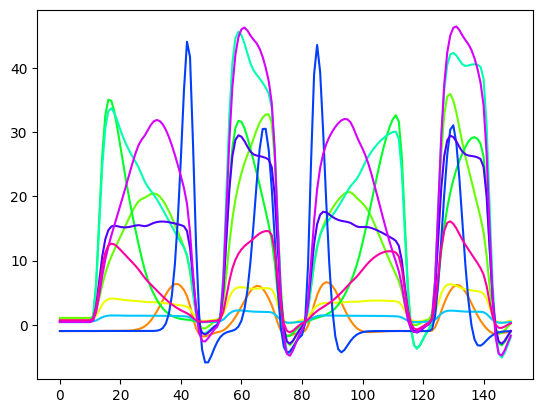

In [5]:
pred = model.predict()
for i in range(n_vx):
    plt.plot(
        pred.iloc[:,i],
        color=idx_cols[i]
    )

## Noisy predictions

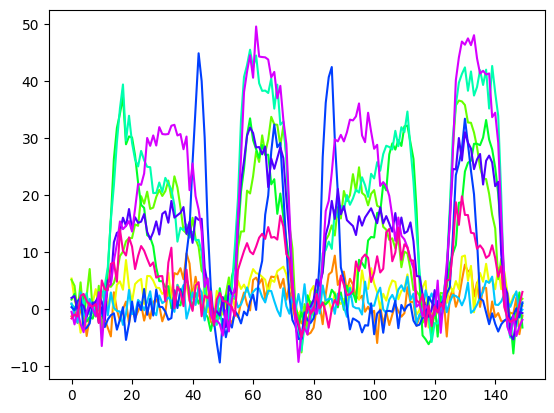

In [6]:
data = model.simulate(noise=2)
for i in range(n_vx):
    plt.plot(
        data.iloc[:,i],
        color=idx_cols[i]
    )

# Estimate parameters

In [7]:
from braincoder.optimize import ParameterFitter
from braincoder.bprf_mcmc import BPRF

/home/daghlian/.conda/envs/bcoder2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
model = GaussianPRF2DWithHRF(grid_coordinates, 
                      paradigm=paradigm,
                     parameters=parameters,
                      hrf_model=SPMHRFModel(tr=1.7))
cfitter = ParameterFitter(model, data, paradigm)


grid_pars = cfitter.fit_grid(x=np.linspace(-1, 1, 20), 
                            y=np.linspace(-aspect_ratio, aspect_ratio, 20),
                            sd=np.linspace(0.01, 1., 10),
                            baseline=[0.0],
                            amplitude=[1.0],
                            use_correlation_cost=True)
ols_pars = cfitter.refine_baseline_and_amplitude(grid_pars)
refined_pars = cfitter.fit(init_pars=ols_pars)

Working with chunk size of 444444
Using correlation cost!


  0%|                                                                                                                            | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]

Number of problematic voxels (mask): 0
Number of voxels remaining (mask): 10


  0%|                                                                                                                         | 0/1000 [00:00<?, ?it/s]

2025-02-18 11:25:14.282609: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x555ba4470330 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-02-18 11:25:14.282659: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2025-02-18 11:25:14.290302: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-18 11:25:14.326577: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-02-18 11:25:14.328131: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
Current R2: 0.78285/Best R2: 0.78285:   0%|                                                                                   | 0/1000 [00:01<?, ?it/s]

Current R2: 0.78285/Best R2: 0.78285:   0%|                                                                           | 1/1000 [00:01<24:50,  1.49s/it]

Current R2: 0.78311/Best R2: 0.78337:   0%|                                                                           | 1/1000 [00:01<24:50,  1.49s/it]

Current R2: 0.78373/Best R2: 0.78373:   0%|                                                                           | 1/1000 [00:01<24:50,  1.49s/it]

Current R2: 0.78392/Best R2: 0.78403:   0%|                                                                           | 1/1000 [00:01<24:50,  1.49s/it]

Current R2: 0.78412/Best R2: 0.78427:   0%|                                                                           | 1/1000 [00:01<24:50,  1.49s/it]

Current R2: 0.78440/Best R2: 0.78446:   0%|                                                                           | 1/1000 [00:01<24:50,  1.49s/it]

Current R2: 0.78440/Best R2: 0.78446:   1%|▍                                                                          | 6/1000 [00:01<03:21,  4.93it/s]

Current R2: 0.78464/Best R2: 0.78465:   1%|▍                                                                          | 6/1000 [00:01<03:21,  4.93it/s]

Current R2: 0.78477/Best R2: 0.78480:   1%|▍                                                                          | 6/1000 [00:01<03:21,  4.93it/s]

Current R2: 0.78485/Best R2: 0.78491:   1%|▍                                                                          | 6/1000 [00:01<03:21,  4.93it/s]

Current R2: 0.78495/Best R2: 0.78501:   1%|▍                                                                          | 6/1000 [00:01<03:21,  4.93it/s]

Current R2: 0.78511/Best R2: 0.78513:   1%|▍                                                                          | 6/1000 [00:01<03:21,  4.93it/s]

Current R2: 0.78511/Best R2: 0.78513:   1%|▊                                                                         | 11/1000 [00:01<01:41,  9.73it/s]

Current R2: 0.78526/Best R2: 0.78526:   1%|▊                                                                         | 11/1000 [00:01<01:41,  9.73it/s]

Current R2: 0.78535/Best R2: 0.78536:   1%|▊                                                                         | 11/1000 [00:01<01:41,  9.73it/s]

Current R2: 0.78539/Best R2: 0.78543:   1%|▊                                                                         | 11/1000 [00:01<01:41,  9.73it/s]

Current R2: 0.78545/Best R2: 0.78549:   1%|▊                                                                         | 11/1000 [00:01<01:41,  9.73it/s]

Current R2: 0.78555/Best R2: 0.78557:   1%|▊                                                                         | 11/1000 [00:01<01:41,  9.73it/s]

Current R2: 0.78555/Best R2: 0.78557:   2%|█▏                                                                        | 16/1000 [00:01<01:05, 15.08it/s]

Current R2: 0.78565/Best R2: 0.78566:   2%|█▏                                                                        | 16/1000 [00:01<01:05, 15.08it/s]

Current R2: 0.78573/Best R2: 0.78574:   2%|█▏                                                                        | 16/1000 [00:01<01:05, 15.08it/s]

Current R2: 0.78578/Best R2: 0.78579:   2%|█▏                                                                        | 16/1000 [00:01<01:05, 15.08it/s]

Current R2: 0.78582/Best R2: 0.78584:   2%|█▏                                                                        | 16/1000 [00:01<01:05, 15.08it/s]

Current R2: 0.78587/Best R2: 0.78588:   2%|█▏                                                                        | 16/1000 [00:01<01:05, 15.08it/s]

Current R2: 0.78593/Best R2: 0.78593:   2%|█▏                                                                        | 16/1000 [00:01<01:05, 15.08it/s]

Current R2: 0.78593/Best R2: 0.78593:   2%|█▋                                                                        | 22/1000 [00:01<00:45, 21.67it/s]

Current R2: 0.78598/Best R2: 0.78598:   2%|█▋                                                                        | 22/1000 [00:01<00:45, 21.67it/s]

Current R2: 0.78602/Best R2: 0.78602:   2%|█▋                                                                        | 22/1000 [00:01<00:45, 21.67it/s]

Current R2: 0.78605/Best R2: 0.78606:   2%|█▋                                                                        | 22/1000 [00:01<00:45, 21.67it/s]

Current R2: 0.78608/Best R2: 0.78609:   2%|█▋                                                                        | 22/1000 [00:02<00:45, 21.67it/s]

Current R2: 0.78612/Best R2: 0.78612:   2%|█▋                                                                        | 22/1000 [00:02<00:45, 21.67it/s]

Current R2: 0.78612/Best R2: 0.78612:   3%|█▉                                                                        | 27/1000 [00:02<00:36, 26.78it/s]

Current R2: 0.78615/Best R2: 0.78615:   3%|█▉                                                                        | 27/1000 [00:02<00:36, 26.78it/s]

Current R2: 0.78618/Best R2: 0.78618:   3%|█▉                                                                        | 27/1000 [00:02<00:36, 26.78it/s]

Current R2: 0.78620/Best R2: 0.78621:   3%|█▉                                                                        | 27/1000 [00:02<00:36, 26.78it/s]

Current R2: 0.78622/Best R2: 0.78623:   3%|█▉                                                                        | 27/1000 [00:02<00:36, 26.78it/s]

Current R2: 0.78624/Best R2: 0.78625:   3%|█▉                                                                        | 27/1000 [00:02<00:36, 26.78it/s]

Current R2: 0.78624/Best R2: 0.78625:   3%|██▎                                                                       | 32/1000 [00:02<00:30, 31.40it/s]

Current R2: 0.78627/Best R2: 0.78627:   3%|██▎                                                                       | 32/1000 [00:02<00:30, 31.40it/s]

Current R2: 0.78629/Best R2: 0.78630:   3%|██▎                                                                       | 32/1000 [00:02<00:30, 31.40it/s]

Current R2: 0.78631/Best R2: 0.78632:   3%|██▎                                                                       | 32/1000 [00:02<00:30, 31.40it/s]

Current R2: 0.78634/Best R2: 0.78634:   3%|██▎                                                                       | 32/1000 [00:02<00:30, 31.40it/s]

Current R2: 0.78636/Best R2: 0.78636:   3%|██▎                                                                       | 32/1000 [00:02<00:30, 31.40it/s]

Current R2: 0.78636/Best R2: 0.78636:   4%|██▋                                                                       | 37/1000 [00:02<00:27, 35.36it/s]

Current R2: 0.78638/Best R2: 0.78638:   4%|██▋                                                                       | 37/1000 [00:02<00:27, 35.36it/s]

Current R2: 0.78640/Best R2: 0.78640:   4%|██▋                                                                       | 37/1000 [00:02<00:27, 35.36it/s]

Current R2: 0.78642/Best R2: 0.78642:   4%|██▋                                                                       | 37/1000 [00:02<00:27, 35.36it/s]

Current R2: 0.78644/Best R2: 0.78644:   4%|██▋                                                                       | 37/1000 [00:02<00:27, 35.36it/s]

Current R2: 0.78646/Best R2: 0.78646:   4%|██▋                                                                       | 37/1000 [00:02<00:27, 35.36it/s]

Current R2: 0.78646/Best R2: 0.78646:   4%|███                                                                       | 42/1000 [00:02<00:24, 38.68it/s]

Current R2: 0.78648/Best R2: 0.78648:   4%|███                                                                       | 42/1000 [00:02<00:24, 38.68it/s]

Current R2: 0.78649/Best R2: 0.78650:   4%|███                                                                       | 42/1000 [00:02<00:24, 38.68it/s]

Current R2: 0.78651/Best R2: 0.78651:   4%|███                                                                       | 42/1000 [00:02<00:24, 38.68it/s]

Current R2: 0.78653/Best R2: 0.78653:   4%|███                                                                       | 42/1000 [00:02<00:24, 38.68it/s]

Current R2: 0.78654/Best R2: 0.78655:   4%|███                                                                       | 42/1000 [00:02<00:24, 38.68it/s]

Current R2: 0.78654/Best R2: 0.78655:   5%|███▍                                                                      | 47/1000 [00:02<00:23, 40.83it/s]

Current R2: 0.78656/Best R2: 0.78656:   5%|███▍                                                                      | 47/1000 [00:02<00:23, 40.83it/s]

Current R2: 0.78658/Best R2: 0.78658:   5%|███▍                                                                      | 47/1000 [00:02<00:23, 40.83it/s]

Current R2: 0.78659/Best R2: 0.78659:   5%|███▍                                                                      | 47/1000 [00:02<00:23, 40.83it/s]

Current R2: 0.78661/Best R2: 0.78661:   5%|███▍                                                                      | 47/1000 [00:02<00:23, 40.83it/s]

Current R2: 0.78662/Best R2: 0.78662:   5%|███▍                                                                      | 47/1000 [00:02<00:23, 40.83it/s]

Current R2: 0.78664/Best R2: 0.78664:   5%|███▍                                                                      | 47/1000 [00:02<00:23, 40.83it/s]

Current R2: 0.78664/Best R2: 0.78664:   5%|███▉                                                                      | 53/1000 [00:02<00:21, 43.81it/s]

Current R2: 0.78665/Best R2: 0.78665:   5%|███▉                                                                      | 53/1000 [00:02<00:21, 43.81it/s]

Current R2: 0.78666/Best R2: 0.78666:   5%|███▉                                                                      | 53/1000 [00:02<00:21, 43.81it/s]

Current R2: 0.78667/Best R2: 0.78667:   5%|███▉                                                                      | 53/1000 [00:02<00:21, 43.81it/s]

Current R2: 0.78669/Best R2: 0.78669:   5%|███▉                                                                      | 53/1000 [00:02<00:21, 43.81it/s]

Current R2: 0.78670/Best R2: 0.78670:   5%|███▉                                                                      | 53/1000 [00:02<00:21, 43.81it/s]

Current R2: 0.78671/Best R2: 0.78671:   5%|███▉                                                                      | 53/1000 [00:02<00:21, 43.81it/s]

Current R2: 0.78671/Best R2: 0.78671:   6%|████▎                                                                     | 59/1000 [00:02<00:20, 46.19it/s]

Current R2: 0.78672/Best R2: 0.78672:   6%|████▎                                                                     | 59/1000 [00:02<00:20, 46.19it/s]

Current R2: 0.78673/Best R2: 0.78673:   6%|████▎                                                                     | 59/1000 [00:02<00:20, 46.19it/s]

Current R2: 0.78674/Best R2: 0.78674:   6%|████▎                                                                     | 59/1000 [00:02<00:20, 46.19it/s]

Current R2: 0.78675/Best R2: 0.78675:   6%|████▎                                                                     | 59/1000 [00:02<00:20, 46.19it/s]

Current R2: 0.78676/Best R2: 0.78676:   6%|████▎                                                                     | 59/1000 [00:02<00:20, 46.19it/s]

Current R2: 0.78677/Best R2: 0.78677:   6%|████▎                                                                     | 59/1000 [00:02<00:20, 46.19it/s]

Current R2: 0.78677/Best R2: 0.78677:   6%|████▊                                                                     | 65/1000 [00:02<00:19, 48.01it/s]

Current R2: 0.78678/Best R2: 0.78678:   6%|████▊                                                                     | 65/1000 [00:02<00:19, 48.01it/s]

Current R2: 0.78679/Best R2: 0.78679:   6%|████▊                                                                     | 65/1000 [00:02<00:19, 48.01it/s]

Current R2: 0.78680/Best R2: 0.78680:   6%|████▊                                                                     | 65/1000 [00:02<00:19, 48.01it/s]

Current R2: 0.78681/Best R2: 0.78681:   6%|████▊                                                                     | 65/1000 [00:02<00:19, 48.01it/s]

Current R2: 0.78682/Best R2: 0.78682:   6%|████▊                                                                     | 65/1000 [00:02<00:19, 48.01it/s]

Current R2: 0.78683/Best R2: 0.78683:   6%|████▊                                                                     | 65/1000 [00:02<00:19, 48.01it/s]

Current R2: 0.78683/Best R2: 0.78683:   7%|█████▎                                                                    | 71/1000 [00:02<00:18, 49.49it/s]

Current R2: 0.78684/Best R2: 0.78684:   7%|█████▎                                                                    | 71/1000 [00:02<00:18, 49.49it/s]

Current R2: 0.78685/Best R2: 0.78685:   7%|█████▎                                                                    | 71/1000 [00:02<00:18, 49.49it/s]

Current R2: 0.78685/Best R2: 0.78685:   7%|█████▎                                                                    | 71/1000 [00:02<00:18, 49.49it/s]

Current R2: 0.78686/Best R2: 0.78686:   7%|█████▎                                                                    | 71/1000 [00:02<00:18, 49.49it/s]

Current R2: 0.78687/Best R2: 0.78687:   7%|█████▎                                                                    | 71/1000 [00:03<00:18, 49.49it/s]

Current R2: 0.78688/Best R2: 0.78688:   7%|█████▎                                                                    | 71/1000 [00:03<00:18, 49.49it/s]

Current R2: 0.78688/Best R2: 0.78688:   8%|█████▋                                                                    | 77/1000 [00:03<00:18, 50.06it/s]

Current R2: 0.78688/Best R2: 0.78688:   8%|█████▋                                                                    | 77/1000 [00:03<00:18, 50.06it/s]

Current R2: 0.78689/Best R2: 0.78689:   8%|█████▋                                                                    | 77/1000 [00:03<00:18, 50.06it/s]

Current R2: 0.78690/Best R2: 0.78690:   8%|█████▋                                                                    | 77/1000 [00:03<00:18, 50.06it/s]

Current R2: 0.78691/Best R2: 0.78691:   8%|█████▋                                                                    | 77/1000 [00:03<00:18, 50.06it/s]

Current R2: 0.78691/Best R2: 0.78691:   8%|█████▋                                                                    | 77/1000 [00:03<00:18, 50.06it/s]

Current R2: 0.78692/Best R2: 0.78692:   8%|█████▋                                                                    | 77/1000 [00:03<00:18, 50.06it/s]

Current R2: 0.78692/Best R2: 0.78692:   8%|██████▏                                                                   | 83/1000 [00:03<00:17, 50.97it/s]

Current R2: 0.78693/Best R2: 0.78693:   8%|██████▏                                                                   | 83/1000 [00:03<00:17, 50.97it/s]

Current R2: 0.78693/Best R2: 0.78693:   8%|██████▏                                                                   | 83/1000 [00:03<00:17, 50.97it/s]

Current R2: 0.78694/Best R2: 0.78694:   8%|██████▏                                                                   | 83/1000 [00:03<00:17, 50.97it/s]

Current R2: 0.78695/Best R2: 0.78695:   8%|██████▏                                                                   | 83/1000 [00:03<00:17, 50.97it/s]

Current R2: 0.78695/Best R2: 0.78695:   8%|██████▏                                                                   | 83/1000 [00:03<00:17, 50.97it/s]

Current R2: 0.78696/Best R2: 0.78696:   8%|██████▏                                                                   | 83/1000 [00:03<00:17, 50.97it/s]

Current R2: 0.78696/Best R2: 0.78696:   9%|██████▌                                                                   | 89/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78696/Best R2: 0.78696:   9%|██████▌                                                                   | 89/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78697/Best R2: 0.78697:   9%|██████▌                                                                   | 89/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78698/Best R2: 0.78698:   9%|██████▌                                                                   | 89/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78698/Best R2: 0.78698:   9%|██████▌                                                                   | 89/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78699/Best R2: 0.78699:   9%|██████▌                                                                   | 89/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78699/Best R2: 0.78699:   9%|██████▌                                                                   | 89/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78699/Best R2: 0.78699:  10%|███████                                                                   | 95/1000 [00:03<00:17, 50.40it/s]

Current R2: 0.78700/Best R2: 0.78700:  10%|███████                                                                   | 95/1000 [00:03<00:17, 50.40it/s]

Current R2: 0.78700/Best R2: 0.78700:  10%|███████                                                                   | 95/1000 [00:03<00:17, 50.40it/s]

Current R2: 0.78701/Best R2: 0.78701:  10%|███████                                                                   | 95/1000 [00:03<00:17, 50.40it/s]

Current R2: 0.78701/Best R2: 0.78701:  10%|███████                                                                   | 95/1000 [00:03<00:17, 50.40it/s]

Current R2: 0.78702/Best R2: 0.78702:  10%|███████                                                                   | 95/1000 [00:03<00:17, 50.40it/s]

Current R2: 0.78702/Best R2: 0.78702:  10%|███████                                                                   | 95/1000 [00:03<00:17, 50.40it/s]

Current R2: 0.78702/Best R2: 0.78702:  10%|███████▎                                                                 | 101/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78703/Best R2: 0.78703:  10%|███████▎                                                                 | 101/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78703/Best R2: 0.78703:  10%|███████▎                                                                 | 101/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78704/Best R2: 0.78704:  10%|███████▎                                                                 | 101/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78704/Best R2: 0.78704:  10%|███████▎                                                                 | 101/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78705/Best R2: 0.78705:  10%|███████▎                                                                 | 101/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78705/Best R2: 0.78705:  10%|███████▎                                                                 | 101/1000 [00:03<00:17, 51.54it/s]

Current R2: 0.78705/Best R2: 0.78705:  11%|███████▊                                                                 | 107/1000 [00:03<00:17, 51.70it/s]

Current R2: 0.78706/Best R2: 0.78706:  11%|███████▊                                                                 | 107/1000 [00:03<00:17, 51.70it/s]

Current R2: 0.78706/Best R2: 0.78706:  11%|███████▊                                                                 | 107/1000 [00:03<00:17, 51.70it/s]

Current R2: 0.78706/Best R2: 0.78706:  11%|███████▊                                                                 | 107/1000 [00:03<00:17, 51.70it/s]

Current R2: 0.78707/Best R2: 0.78707:  11%|███████▊                                                                 | 107/1000 [00:03<00:17, 51.70it/s]

Current R2: 0.78707/Best R2: 0.78707:  11%|███████▊                                                                 | 107/1000 [00:03<00:17, 51.70it/s]

Current R2: 0.78708/Best R2: 0.78708:  11%|███████▊                                                                 | 107/1000 [00:03<00:17, 51.70it/s]

Current R2: 0.78708/Best R2: 0.78708:  11%|████████▏                                                                | 113/1000 [00:03<00:16, 52.24it/s]

Current R2: 0.78708/Best R2: 0.78708:  11%|████████▏                                                                | 113/1000 [00:03<00:16, 52.24it/s]

Current R2: 0.78708/Best R2: 0.78708:  11%|████████▏                                                                | 113/1000 [00:03<00:16, 52.24it/s]

Current R2: 0.78709/Best R2: 0.78709:  11%|████████▏                                                                | 113/1000 [00:03<00:16, 52.24it/s]

Current R2: 0.78709/Best R2: 0.78709:  11%|████████▏                                                                | 113/1000 [00:03<00:16, 52.24it/s]

Current R2: 0.78710/Best R2: 0.78710:  11%|████████▏                                                                | 113/1000 [00:03<00:16, 52.24it/s]

Current R2: 0.78710/Best R2: 0.78710:  11%|████████▏                                                                | 113/1000 [00:03<00:16, 52.24it/s]

Current R2: 0.78710/Best R2: 0.78710:  12%|████████▋                                                                | 119/1000 [00:03<00:16, 52.51it/s]

Current R2: 0.78710/Best R2: 0.78710:  12%|████████▋                                                                | 119/1000 [00:03<00:16, 52.51it/s]

Current R2: 0.78711/Best R2: 0.78711:  12%|████████▋                                                                | 119/1000 [00:03<00:16, 52.51it/s]

Current R2: 0.78711/Best R2: 0.78711:  12%|████████▋                                                                | 119/1000 [00:03<00:16, 52.51it/s]

Current R2: 0.78711/Best R2: 0.78711:  12%|████████▋                                                                | 119/1000 [00:03<00:16, 52.51it/s]

Current R2: 0.78712/Best R2: 0.78712:  12%|████████▋                                                                | 119/1000 [00:03<00:16, 52.51it/s]

Current R2: 0.78712/Best R2: 0.78712:  12%|████████▋                                                                | 119/1000 [00:03<00:16, 52.51it/s]

Current R2: 0.78712/Best R2: 0.78712:  12%|█████████▏                                                               | 125/1000 [00:03<00:16, 52.72it/s]

Current R2: 0.78712/Best R2: 0.78712:  12%|█████████▏                                                               | 125/1000 [00:03<00:16, 52.72it/s]

Current R2: 0.78713/Best R2: 0.78713:  12%|█████████▏                                                               | 125/1000 [00:03<00:16, 52.72it/s]

Current R2: 0.78713/Best R2: 0.78713:  12%|█████████▏                                                               | 125/1000 [00:04<00:16, 52.72it/s]

Current R2: 0.78713/Best R2: 0.78713:  12%|█████████▏                                                               | 125/1000 [00:04<00:16, 52.72it/s]

Current R2: 0.78714/Best R2: 0.78714:  12%|█████████▏                                                               | 125/1000 [00:04<00:16, 52.72it/s]

Current R2: 0.78714/Best R2: 0.78714:  12%|█████████▏                                                               | 125/1000 [00:04<00:16, 52.72it/s]

Current R2: 0.78714/Best R2: 0.78714:  13%|█████████▌                                                               | 131/1000 [00:04<00:16, 52.02it/s]

Current R2: 0.78714/Best R2: 0.78714:  13%|█████████▌                                                               | 131/1000 [00:04<00:16, 52.02it/s]

Current R2: 0.78715/Best R2: 0.78715:  13%|█████████▌                                                               | 131/1000 [00:04<00:16, 52.02it/s]

Current R2: 0.78715/Best R2: 0.78715:  13%|█████████▌                                                               | 131/1000 [00:04<00:16, 52.02it/s]

Current R2: 0.78715/Best R2: 0.78715:  13%|█████████▌                                                               | 131/1000 [00:04<00:16, 52.02it/s]

Current R2: 0.78715/Best R2: 0.78715:  13%|█████████▌                                                               | 131/1000 [00:04<00:16, 52.02it/s]

Current R2: 0.78716/Best R2: 0.78716:  13%|█████████▌                                                               | 131/1000 [00:04<00:16, 52.02it/s]

Current R2: 0.78716/Best R2: 0.78716:  14%|██████████                                                               | 137/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78716/Best R2: 0.78716:  14%|██████████                                                               | 137/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78716/Best R2: 0.78716:  14%|██████████                                                               | 137/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78717/Best R2: 0.78717:  14%|██████████                                                               | 137/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78717/Best R2: 0.78717:  14%|██████████                                                               | 137/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78717/Best R2: 0.78717:  14%|██████████                                                               | 137/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78717/Best R2: 0.78717:  14%|██████████                                                               | 137/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78717/Best R2: 0.78717:  14%|██████████▍                                                              | 143/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78718/Best R2: 0.78718:  14%|██████████▍                                                              | 143/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78718/Best R2: 0.78718:  14%|██████████▍                                                              | 143/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78718/Best R2: 0.78718:  14%|██████████▍                                                              | 143/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78718/Best R2: 0.78718:  14%|██████████▍                                                              | 143/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78719/Best R2: 0.78719:  14%|██████████▍                                                              | 143/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78719/Best R2: 0.78719:  14%|██████████▍                                                              | 143/1000 [00:04<00:16, 52.05it/s]

Current R2: 0.78719/Best R2: 0.78719:  15%|██████████▉                                                              | 149/1000 [00:04<00:16, 52.45it/s]

Current R2: 0.78719/Best R2: 0.78719:  15%|██████████▉                                                              | 149/1000 [00:04<00:16, 52.45it/s]

Current R2: 0.78719/Best R2: 0.78719:  15%|██████████▉                                                              | 149/1000 [00:04<00:16, 52.45it/s]

Current R2: 0.78720/Best R2: 0.78720:  15%|██████████▉                                                              | 149/1000 [00:04<00:16, 52.45it/s]

Current R2: 0.78720/Best R2: 0.78720:  15%|██████████▉                                                              | 149/1000 [00:04<00:16, 52.45it/s]

Current R2: 0.78720/Best R2: 0.78720:  15%|██████████▉                                                              | 149/1000 [00:04<00:16, 52.45it/s]

Current R2: 0.78720/Best R2: 0.78720:  15%|██████████▉                                                              | 149/1000 [00:04<00:16, 52.45it/s]

Current R2: 0.78720/Best R2: 0.78720:  16%|███████████▎                                                             | 155/1000 [00:04<00:16, 52.21it/s]

Current R2: 0.78721/Best R2: 0.78721:  16%|███████████▎                                                             | 155/1000 [00:04<00:16, 52.21it/s]

Current R2: 0.78721/Best R2: 0.78721:  16%|███████████▎                                                             | 155/1000 [00:04<00:16, 52.21it/s]

Current R2: 0.78721/Best R2: 0.78721:  16%|███████████▎                                                             | 155/1000 [00:04<00:16, 52.21it/s]

Current R2: 0.78721/Best R2: 0.78721:  16%|███████████▎                                                             | 155/1000 [00:04<00:16, 52.21it/s]

Current R2: 0.78721/Best R2: 0.78721:  16%|███████████▎                                                             | 155/1000 [00:04<00:16, 52.21it/s]

Current R2: 0.78722/Best R2: 0.78722:  16%|███████████▎                                                             | 155/1000 [00:04<00:16, 52.21it/s]

Current R2: 0.78722/Best R2: 0.78722:  16%|███████████▊                                                             | 161/1000 [00:04<00:16, 51.99it/s]

Current R2: 0.78722/Best R2: 0.78722:  16%|███████████▊                                                             | 161/1000 [00:04<00:16, 51.99it/s]

Current R2: 0.78722/Best R2: 0.78722:  16%|███████████▊                                                             | 161/1000 [00:04<00:16, 51.99it/s]

Current R2: 0.78722/Best R2: 0.78722:  16%|███████████▊                                                             | 161/1000 [00:04<00:16, 51.99it/s]

Current R2: 0.78722/Best R2: 0.78722:  16%|███████████▊                                                             | 161/1000 [00:04<00:16, 51.99it/s]

Current R2: 0.78723/Best R2: 0.78723:  16%|███████████▊                                                             | 161/1000 [00:04<00:16, 51.99it/s]

Current R2: 0.78723/Best R2: 0.78723:  16%|███████████▊                                                             | 161/1000 [00:04<00:16, 51.99it/s]

Current R2: 0.78723/Best R2: 0.78723:  17%|████████████▏                                                            | 167/1000 [00:04<00:17, 47.97it/s]

Current R2: 0.78723/Best R2: 0.78723:  17%|████████████▏                                                            | 167/1000 [00:04<00:17, 47.97it/s]

Current R2: 0.78723/Best R2: 0.78723:  17%|████████████▏                                                            | 167/1000 [00:04<00:17, 47.97it/s]

Current R2: 0.78723/Best R2: 0.78723:  17%|████████████▏                                                            | 167/1000 [00:04<00:17, 47.97it/s]

Current R2: 0.78724/Best R2: 0.78724:  17%|████████████▏                                                            | 167/1000 [00:04<00:17, 47.97it/s]

Current R2: 0.78724/Best R2: 0.78724:  17%|████████████▏                                                            | 167/1000 [00:04<00:17, 47.97it/s]

Current R2: 0.78724/Best R2: 0.78724:  17%|████████████▌                                                            | 172/1000 [00:04<00:17, 47.41it/s]

Current R2: 0.78724/Best R2: 0.78724:  17%|████████████▌                                                            | 172/1000 [00:04<00:17, 47.41it/s]

Current R2: 0.78724/Best R2: 0.78724:  17%|████████████▌                                                            | 172/1000 [00:04<00:17, 47.41it/s]

Current R2: 0.78724/Best R2: 0.78724:  17%|████████████▌                                                            | 172/1000 [00:04<00:17, 47.41it/s]

Current R2: 0.78725/Best R2: 0.78725:  17%|████████████▌                                                            | 172/1000 [00:05<00:17, 47.41it/s]

Current R2: 0.78725/Best R2: 0.78725:  17%|████████████▌                                                            | 172/1000 [00:05<00:17, 47.41it/s]

Current R2: 0.78725/Best R2: 0.78725:  18%|████████████▉                                                            | 177/1000 [00:05<00:18, 43.82it/s]

Current R2: 0.78725/Best R2: 0.78725:  18%|████████████▉                                                            | 177/1000 [00:05<00:18, 43.82it/s]

Current R2: 0.78725/Best R2: 0.78725:  18%|████████████▉                                                            | 177/1000 [00:05<00:18, 43.82it/s]

Current R2: 0.78725/Best R2: 0.78725:  18%|████████████▉                                                            | 177/1000 [00:05<00:18, 43.82it/s]

Current R2: 0.78725/Best R2: 0.78725:  18%|████████████▉                                                            | 177/1000 [00:05<00:18, 43.82it/s]

Current R2: 0.78726/Best R2: 0.78726:  18%|████████████▉                                                            | 177/1000 [00:05<00:18, 43.82it/s]

Current R2: 0.78726/Best R2: 0.78726:  18%|█████████████▎                                                           | 182/1000 [00:05<00:18, 43.36it/s]

Current R2: 0.78726/Best R2: 0.78726:  18%|█████████████▎                                                           | 182/1000 [00:05<00:18, 43.36it/s]

Current R2: 0.78726/Best R2: 0.78726:  18%|█████████████▎                                                           | 182/1000 [00:05<00:18, 43.36it/s]

Current R2: 0.78726/Best R2: 0.78726:  18%|█████████████▎                                                           | 182/1000 [00:05<00:18, 43.36it/s]

Current R2: 0.78726/Best R2: 0.78726:  18%|█████████████▎                                                           | 182/1000 [00:05<00:18, 43.36it/s]

Current R2: 0.78726/Best R2: 0.78726:  18%|█████████████▎                                                           | 182/1000 [00:05<00:18, 43.36it/s]

Current R2: 0.78726/Best R2: 0.78726:  19%|█████████████▋                                                           | 187/1000 [00:05<00:18, 44.32it/s]

Current R2: 0.78727/Best R2: 0.78727:  19%|█████████████▋                                                           | 187/1000 [00:05<00:18, 44.32it/s]

Current R2: 0.78727/Best R2: 0.78727:  19%|█████████████▋                                                           | 187/1000 [00:05<00:18, 44.32it/s]

Current R2: 0.78727/Best R2: 0.78727:  19%|█████████████▋                                                           | 187/1000 [00:05<00:18, 44.32it/s]

Current R2: 0.78727/Best R2: 0.78727:  19%|█████████████▋                                                           | 187/1000 [00:05<00:18, 44.32it/s]

Current R2: 0.78727/Best R2: 0.78727:  19%|█████████████▋                                                           | 187/1000 [00:05<00:18, 44.32it/s]

Current R2: 0.78727/Best R2: 0.78727:  19%|██████████████                                                           | 192/1000 [00:05<00:18, 44.83it/s]

Current R2: 0.78727/Best R2: 0.78727:  19%|██████████████                                                           | 192/1000 [00:05<00:18, 44.83it/s]

Current R2: 0.78728/Best R2: 0.78728:  19%|██████████████                                                           | 192/1000 [00:05<00:18, 44.83it/s]

Current R2: 0.78728/Best R2: 0.78728:  19%|██████████████                                                           | 192/1000 [00:05<00:18, 44.83it/s]

Current R2: 0.78728/Best R2: 0.78728:  19%|██████████████                                                           | 192/1000 [00:05<00:18, 44.83it/s]

Current R2: 0.78728/Best R2: 0.78728:  19%|██████████████                                                           | 192/1000 [00:05<00:18, 44.83it/s]

Current R2: 0.78728/Best R2: 0.78728:  20%|██████████████▍                                                          | 197/1000 [00:05<00:17, 45.84it/s]

Current R2: 0.78728/Best R2: 0.78728:  20%|██████████████▍                                                          | 197/1000 [00:05<00:17, 45.84it/s]

Current R2: 0.78728/Best R2: 0.78728:  20%|██████████████▍                                                          | 197/1000 [00:05<00:17, 45.84it/s]

Current R2: 0.78728/Best R2: 0.78728:  20%|██████████████▍                                                          | 197/1000 [00:05<00:17, 45.84it/s]

Current R2: 0.78729/Best R2: 0.78729:  20%|██████████████▍                                                          | 197/1000 [00:05<00:17, 45.84it/s]

Current R2: 0.78729/Best R2: 0.78729:  20%|██████████████▍                                                          | 197/1000 [00:05<00:17, 45.84it/s]

Current R2: 0.78729/Best R2: 0.78729:  20%|██████████████▋                                                          | 202/1000 [00:05<00:17, 45.85it/s]

Current R2: 0.78729/Best R2: 0.78729:  20%|██████████████▋                                                          | 202/1000 [00:05<00:17, 45.85it/s]

Current R2: 0.78729/Best R2: 0.78729:  20%|██████████████▋                                                          | 202/1000 [00:05<00:17, 45.85it/s]

Current R2: 0.78729/Best R2: 0.78729:  20%|██████████████▋                                                          | 202/1000 [00:05<00:17, 45.85it/s]

Current R2: 0.78729/Best R2: 0.78729:  20%|██████████████▋                                                          | 202/1000 [00:05<00:17, 45.85it/s]

Current R2: 0.78729/Best R2: 0.78729:  20%|██████████████▋                                                          | 202/1000 [00:05<00:17, 45.85it/s]

Current R2: 0.78729/Best R2: 0.78729:  21%|███████████████                                                          | 207/1000 [00:05<00:17, 45.69it/s]

Current R2: 0.78730/Best R2: 0.78730:  21%|███████████████                                                          | 207/1000 [00:05<00:17, 45.69it/s]

Current R2: 0.78730/Best R2: 0.78730:  21%|███████████████                                                          | 207/1000 [00:05<00:17, 45.69it/s]

Current R2: 0.78730/Best R2: 0.78730:  21%|███████████████                                                          | 207/1000 [00:05<00:17, 45.69it/s]

Current R2: 0.78730/Best R2: 0.78730:  21%|███████████████                                                          | 207/1000 [00:05<00:17, 45.69it/s]

Current R2: 0.78730/Best R2: 0.78730:  21%|███████████████                                                          | 207/1000 [00:05<00:17, 45.69it/s]

Current R2: 0.78730/Best R2: 0.78730:  21%|███████████████▍                                                         | 212/1000 [00:05<00:17, 44.94it/s]

Current R2: 0.78730/Best R2: 0.78730:  21%|███████████████▍                                                         | 212/1000 [00:05<00:17, 44.94it/s]

Current R2: 0.78730/Best R2: 0.78730:  21%|███████████████▍                                                         | 212/1000 [00:05<00:17, 44.94it/s]

Current R2: 0.78730/Best R2: 0.78730:  21%|███████████████▍                                                         | 212/1000 [00:05<00:17, 44.94it/s]

Current R2: 0.78731/Best R2: 0.78731:  21%|███████████████▍                                                         | 212/1000 [00:05<00:17, 44.94it/s]

Current R2: 0.78731/Best R2: 0.78731:  21%|███████████████▍                                                         | 212/1000 [00:05<00:17, 44.94it/s]

Current R2: 0.78731/Best R2: 0.78731:  22%|███████████████▊                                                         | 217/1000 [00:05<00:17, 45.46it/s]

Current R2: 0.78731/Best R2: 0.78731:  22%|███████████████▊                                                         | 217/1000 [00:05<00:17, 45.46it/s]

Current R2: 0.78731/Best R2: 0.78731:  22%|███████████████▊                                                         | 217/1000 [00:05<00:17, 45.46it/s]

Current R2: 0.78731/Best R2: 0.78731:  22%|███████████████▊                                                         | 217/1000 [00:05<00:17, 45.46it/s]

Current R2: 0.78731/Best R2: 0.78731:  22%|███████████████▊                                                         | 217/1000 [00:05<00:17, 45.46it/s]

Current R2: 0.78731/Best R2: 0.78731:  22%|███████████████▊                                                         | 217/1000 [00:06<00:17, 45.46it/s]

Current R2: 0.78731/Best R2: 0.78731:  22%|████████████████▏                                                        | 222/1000 [00:06<00:16, 46.19it/s]

Current R2: 0.78731/Best R2: 0.78731:  22%|████████████████▏                                                        | 222/1000 [00:06<00:16, 46.19it/s]

Current R2: 0.78732/Best R2: 0.78732:  22%|████████████████▏                                                        | 222/1000 [00:06<00:16, 46.19it/s]

Current R2: 0.78732/Best R2: 0.78732:  22%|████████████████▏                                                        | 222/1000 [00:06<00:16, 46.19it/s]

Current R2: 0.78732/Best R2: 0.78732:  22%|████████████████▏                                                        | 222/1000 [00:06<00:16, 46.19it/s]

Current R2: 0.78732/Best R2: 0.78732:  22%|████████████████▏                                                        | 222/1000 [00:06<00:16, 46.19it/s]

Current R2: 0.78732/Best R2: 0.78732:  22%|████████████████▏                                                        | 222/1000 [00:06<00:16, 46.19it/s]

Current R2: 0.78732/Best R2: 0.78732:  23%|████████████████▋                                                        | 228/1000 [00:06<00:16, 47.59it/s]

Current R2: 0.78732/Best R2: 0.78732:  23%|████████████████▋                                                        | 228/1000 [00:06<00:16, 47.59it/s]

Current R2: 0.78732/Best R2: 0.78732:  23%|████████████████▋                                                        | 228/1000 [00:06<00:16, 47.59it/s]

Current R2: 0.78732/Best R2: 0.78732:  23%|████████████████▋                                                        | 228/1000 [00:06<00:16, 47.59it/s]

Current R2: 0.78732/Best R2: 0.78732:  23%|████████████████▋                                                        | 228/1000 [00:06<00:16, 47.59it/s]

Current R2: 0.78733/Best R2: 0.78733:  23%|████████████████▋                                                        | 228/1000 [00:06<00:16, 47.59it/s]

Current R2: 0.78733/Best R2: 0.78733:  23%|█████████████████                                                        | 233/1000 [00:06<00:16, 47.49it/s]

Current R2: 0.78733/Best R2: 0.78733:  23%|█████████████████                                                        | 233/1000 [00:06<00:16, 47.49it/s]

Current R2: 0.78733/Best R2: 0.78733:  23%|█████████████████                                                        | 233/1000 [00:06<00:16, 47.49it/s]

Current R2: 0.78733/Best R2: 0.78733:  23%|█████████████████                                                        | 233/1000 [00:06<00:16, 47.49it/s]

Current R2: 0.78733/Best R2: 0.78733:  23%|█████████████████                                                        | 233/1000 [00:06<00:16, 47.49it/s]

Current R2: 0.78733/Best R2: 0.78733:  23%|█████████████████                                                        | 233/1000 [00:06<00:16, 47.49it/s]

Current R2: 0.78733/Best R2: 0.78733:  23%|█████████████████                                                        | 233/1000 [00:06<00:16, 47.49it/s]

Current R2: 0.78733/Best R2: 0.78733:  24%|█████████████████▍                                                       | 239/1000 [00:06<00:15, 49.10it/s]

Current R2: 0.78733/Best R2: 0.78733:  24%|█████████████████▍                                                       | 239/1000 [00:06<00:15, 49.10it/s]

Current R2: 0.78733/Best R2: 0.78733:  24%|█████████████████▍                                                       | 239/1000 [00:06<00:15, 49.10it/s]

Current R2: 0.78733/Best R2: 0.78733:  24%|█████████████████▍                                                       | 239/1000 [00:06<00:15, 49.10it/s]

Current R2: 0.78734/Best R2: 0.78734:  24%|█████████████████▍                                                       | 239/1000 [00:06<00:15, 49.10it/s]

Current R2: 0.78734/Best R2: 0.78734:  24%|█████████████████▍                                                       | 239/1000 [00:06<00:15, 49.10it/s]

Current R2: 0.78734/Best R2: 0.78734:  24%|█████████████████▍                                                       | 239/1000 [00:06<00:15, 49.10it/s]

Current R2: 0.78734/Best R2: 0.78734:  24%|█████████████████▉                                                       | 245/1000 [00:06<00:15, 49.67it/s]

Current R2: 0.78734/Best R2: 0.78734:  24%|█████████████████▉                                                       | 245/1000 [00:06<00:15, 49.67it/s]

Current R2: 0.78734/Best R2: 0.78734:  24%|█████████████████▉                                                       | 245/1000 [00:06<00:15, 49.67it/s]

Current R2: 0.78734/Best R2: 0.78734:  24%|█████████████████▉                                                       | 245/1000 [00:06<00:15, 49.67it/s]

Current R2: 0.78734/Best R2: 0.78734:  24%|█████████████████▉                                                       | 245/1000 [00:06<00:15, 49.67it/s]

Current R2: 0.78734/Best R2: 0.78734:  24%|█████████████████▉                                                       | 245/1000 [00:06<00:15, 49.67it/s]

Current R2: 0.78734/Best R2: 0.78734:  25%|██████████████████▎                                                      | 250/1000 [00:06<00:15, 48.27it/s]

Current R2: 0.78734/Best R2: 0.78734:  25%|██████████████████▎                                                      | 250/1000 [00:06<00:15, 48.27it/s]

Current R2: 0.78734/Best R2: 0.78734:  25%|██████████████████▎                                                      | 250/1000 [00:06<00:15, 48.27it/s]

Current R2: 0.78735/Best R2: 0.78735:  25%|██████████████████▎                                                      | 250/1000 [00:06<00:15, 48.27it/s]

Current R2: 0.78735/Best R2: 0.78735:  25%|██████████████████▎                                                      | 250/1000 [00:06<00:15, 48.27it/s]

Current R2: 0.78735/Best R2: 0.78735:  25%|██████████████████▎                                                      | 250/1000 [00:06<00:15, 48.27it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▌                                                      | 255/1000 [00:06<00:16, 46.50it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▌                                                      | 255/1000 [00:06<00:16, 46.50it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▌                                                      | 255/1000 [00:06<00:16, 46.50it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▌                                                      | 255/1000 [00:06<00:16, 46.50it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▌                                                      | 255/1000 [00:06<00:16, 46.50it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▌                                                      | 255/1000 [00:06<00:16, 46.50it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▉                                                      | 260/1000 [00:06<00:16, 43.83it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▉                                                      | 260/1000 [00:06<00:16, 43.83it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▉                                                      | 260/1000 [00:06<00:16, 43.83it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▉                                                      | 260/1000 [00:06<00:16, 43.83it/s]

Current R2: 0.78735/Best R2: 0.78735:  26%|██████████████████▉                                                      | 260/1000 [00:06<00:16, 43.83it/s]

Current R2: 0.78736/Best R2: 0.78736:  26%|██████████████████▉                                                      | 260/1000 [00:06<00:16, 43.83it/s]

Current R2: 0.78736/Best R2: 0.78736:  26%|███████████████████▎                                                     | 265/1000 [00:06<00:16, 44.86it/s]

Current R2: 0.78736/Best R2: 0.78736:  26%|███████████████████▎                                                     | 265/1000 [00:06<00:16, 44.86it/s]

Current R2: 0.78736/Best R2: 0.78736:  26%|███████████████████▎                                                     | 265/1000 [00:06<00:16, 44.86it/s]

Current R2: 0.78736/Best R2: 0.78736:  26%|███████████████████▎                                                     | 265/1000 [00:07<00:16, 44.86it/s]

Current R2: 0.78736/Best R2: 0.78736:  26%|███████████████████▎                                                     | 265/1000 [00:07<00:16, 44.86it/s]

Current R2: 0.78736/Best R2: 0.78736:  26%|███████████████████▎                                                     | 265/1000 [00:07<00:16, 44.86it/s]

Current R2: 0.78736/Best R2: 0.78736:  27%|███████████████████▋                                                     | 270/1000 [00:07<00:15, 45.79it/s]

Current R2: 0.78736/Best R2: 0.78736:  27%|███████████████████▋                                                     | 270/1000 [00:07<00:15, 45.79it/s]

Current R2: 0.78736/Best R2: 0.78736:  27%|███████████████████▋                                                     | 270/1000 [00:07<00:15, 45.79it/s]

Current R2: 0.78736/Best R2: 0.78736:  27%|███████████████████▋                                                     | 270/1000 [00:07<00:15, 45.79it/s]

Current R2: 0.78736/Best R2: 0.78736:  27%|███████████████████▋                                                     | 270/1000 [00:07<00:15, 45.79it/s]

Current R2: 0.78736/Best R2: 0.78736:  27%|███████████████████▋                                                     | 270/1000 [00:07<00:15, 45.79it/s]

Current R2: 0.78736/Best R2: 0.78736:  28%|████████████████████                                                     | 275/1000 [00:07<00:15, 46.50it/s]

Current R2: 0.78736/Best R2: 0.78736:  28%|████████████████████                                                     | 275/1000 [00:07<00:15, 46.50it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████                                                     | 275/1000 [00:07<00:15, 46.50it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████                                                     | 275/1000 [00:07<00:15, 46.50it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████                                                     | 275/1000 [00:07<00:15, 46.50it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████                                                     | 275/1000 [00:07<00:15, 46.50it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████                                                     | 275/1000 [00:07<00:15, 46.50it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████▌                                                    | 281/1000 [00:07<00:15, 47.46it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████▌                                                    | 281/1000 [00:07<00:15, 47.46it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████▌                                                    | 281/1000 [00:07<00:15, 47.46it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████▌                                                    | 281/1000 [00:07<00:15, 47.46it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████▌                                                    | 281/1000 [00:07<00:15, 47.46it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████▌                                                    | 281/1000 [00:07<00:15, 47.46it/s]

Current R2: 0.78737/Best R2: 0.78737:  28%|████████████████████▌                                                    | 281/1000 [00:07<00:15, 47.46it/s]

Current R2: 0.78737/Best R2: 0.78737:  29%|████████████████████▉                                                    | 287/1000 [00:07<00:14, 49.02it/s]

Current R2: 0.78737/Best R2: 0.78737:  29%|████████████████████▉                                                    | 287/1000 [00:07<00:14, 49.02it/s]

Current R2: 0.78737/Best R2: 0.78737:  29%|████████████████████▉                                                    | 287/1000 [00:07<00:14, 49.02it/s]

Current R2: 0.78737/Best R2: 0.78737:  29%|████████████████████▉                                                    | 287/1000 [00:07<00:14, 49.02it/s]

Current R2: 0.78738/Best R2: 0.78738:  29%|████████████████████▉                                                    | 287/1000 [00:07<00:14, 49.02it/s]

Current R2: 0.78738/Best R2: 0.78738:  29%|████████████████████▉                                                    | 287/1000 [00:07<00:14, 49.02it/s]

Current R2: 0.78738/Best R2: 0.78738:  29%|████████████████████▉                                                    | 287/1000 [00:07<00:14, 49.02it/s]

Current R2: 0.78738/Best R2: 0.78738:  29%|█████████████████████▍                                                   | 293/1000 [00:07<00:13, 50.62it/s]

Current R2: 0.78738/Best R2: 0.78738:  29%|█████████████████████▍                                                   | 293/1000 [00:07<00:13, 50.62it/s]

Current R2: 0.78738/Best R2: 0.78738:  29%|█████████████████████▍                                                   | 293/1000 [00:07<00:13, 50.62it/s]

Current R2: 0.78738/Best R2: 0.78738:  29%|█████████████████████▍                                                   | 293/1000 [00:07<00:13, 50.62it/s]

Current R2: 0.78738/Best R2: 0.78738:  29%|█████████████████████▍                                                   | 293/1000 [00:07<00:13, 50.62it/s]

Current R2: 0.78738/Best R2: 0.78738:  29%|█████████████████████▍                                                   | 293/1000 [00:07<00:13, 50.62it/s]

Current R2: 0.78738/Best R2: 0.78738:  29%|█████████████████████▍                                                   | 293/1000 [00:07<00:13, 50.62it/s]

Current R2: 0.78738/Best R2: 0.78738:  30%|█████████████████████▊                                                   | 299/1000 [00:07<00:13, 51.39it/s]

Current R2: 0.78738/Best R2: 0.78738:  30%|█████████████████████▊                                                   | 299/1000 [00:07<00:13, 51.39it/s]

Current R2: 0.78738/Best R2: 0.78738:  30%|█████████████████████▊                                                   | 299/1000 [00:07<00:13, 51.39it/s]

Current R2: 0.78738/Best R2: 0.78738:  30%|█████████████████████▊                                                   | 299/1000 [00:07<00:13, 51.39it/s]

Current R2: 0.78738/Best R2: 0.78738:  30%|█████████████████████▊                                                   | 299/1000 [00:07<00:13, 51.39it/s]

Current R2: 0.78738/Best R2: 0.78738:  30%|█████████████████████▊                                                   | 299/1000 [00:07<00:13, 51.39it/s]

Current R2: 0.78738/Best R2: 0.78738:  30%|█████████████████████▊                                                   | 299/1000 [00:07<00:13, 51.39it/s]

Current R2: 0.78738/Best R2: 0.78738:  30%|██████████████████████▎                                                  | 305/1000 [00:07<00:13, 52.08it/s]

Current R2: 0.78739/Best R2: 0.78739:  30%|██████████████████████▎                                                  | 305/1000 [00:07<00:13, 52.08it/s]

Current R2: 0.78739/Best R2: 0.78739:  30%|██████████████████████▎                                                  | 305/1000 [00:07<00:13, 52.08it/s]

Current R2: 0.78739/Best R2: 0.78739:  30%|██████████████████████▎                                                  | 305/1000 [00:07<00:13, 52.08it/s]

Current R2: 0.78739/Best R2: 0.78739:  30%|██████████████████████▎                                                  | 305/1000 [00:07<00:13, 52.08it/s]

Current R2: 0.78739/Best R2: 0.78739:  30%|██████████████████████▎                                                  | 305/1000 [00:07<00:13, 52.08it/s]

Current R2: 0.78739/Best R2: 0.78739:  30%|██████████████████████▎                                                  | 305/1000 [00:07<00:13, 52.08it/s]

Current R2: 0.78739/Best R2: 0.78739:  31%|██████████████████████▋                                                  | 311/1000 [00:07<00:13, 51.33it/s]

Current R2: 0.78739/Best R2: 0.78739:  31%|██████████████████████▋                                                  | 311/1000 [00:07<00:13, 51.33it/s]

Current R2: 0.78739/Best R2: 0.78739:  31%|██████████████████████▋                                                  | 311/1000 [00:07<00:13, 51.33it/s]

Current R2: 0.78739/Best R2: 0.78739:  31%|██████████████████████▋                                                  | 311/1000 [00:07<00:13, 51.33it/s]

Current R2: 0.78739/Best R2: 0.78739:  31%|██████████████████████▋                                                  | 311/1000 [00:07<00:13, 51.33it/s]

Current R2: 0.78739/Best R2: 0.78739:  31%|██████████████████████▋                                                  | 311/1000 [00:07<00:13, 51.33it/s]

Current R2: 0.78739/Best R2: 0.78739:  31%|██████████████████████▋                                                  | 311/1000 [00:07<00:13, 51.33it/s]

Current R2: 0.78739/Best R2: 0.78739:  32%|███████████████████████▏                                                 | 317/1000 [00:07<00:13, 50.82it/s]

Current R2: 0.78739/Best R2: 0.78739:  32%|███████████████████████▏                                                 | 317/1000 [00:07<00:13, 50.82it/s]

Current R2: 0.78739/Best R2: 0.78739:  32%|███████████████████████▏                                                 | 317/1000 [00:07<00:13, 50.82it/s]

Current R2: 0.78739/Best R2: 0.78739:  32%|███████████████████████▏                                                 | 317/1000 [00:08<00:13, 50.82it/s]

Current R2: 0.78739/Best R2: 0.78739:  32%|███████████████████████▏                                                 | 317/1000 [00:08<00:13, 50.82it/s]

Current R2: 0.78740/Best R2: 0.78740:  32%|███████████████████████▏                                                 | 317/1000 [00:08<00:13, 50.82it/s]

Current R2: 0.78740/Best R2: 0.78740:  32%|███████████████████████▏                                                 | 317/1000 [00:08<00:13, 50.82it/s]

Current R2: 0.78740/Best R2: 0.78740:  32%|███████████████████████▌                                                 | 323/1000 [00:08<00:13, 50.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  32%|███████████████████████▌                                                 | 323/1000 [00:08<00:13, 50.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  32%|███████████████████████▌                                                 | 323/1000 [00:08<00:13, 50.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  32%|███████████████████████▌                                                 | 323/1000 [00:08<00:13, 50.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  32%|███████████████████████▌                                                 | 323/1000 [00:08<00:13, 50.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  32%|███████████████████████▌                                                 | 323/1000 [00:08<00:13, 50.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  32%|███████████████████████▌                                                 | 323/1000 [00:08<00:13, 50.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████                                                 | 329/1000 [00:08<00:13, 49.53it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████                                                 | 329/1000 [00:08<00:13, 49.53it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████                                                 | 329/1000 [00:08<00:13, 49.53it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████                                                 | 329/1000 [00:08<00:13, 49.53it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████                                                 | 329/1000 [00:08<00:13, 49.53it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████                                                 | 329/1000 [00:08<00:13, 49.53it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████▍                                                | 334/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████▍                                                | 334/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████▍                                                | 334/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████▍                                                | 334/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████▍                                                | 334/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  33%|████████████████████████▍                                                | 334/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78740/Best R2: 0.78740:  34%|████████████████████████▋                                                | 339/1000 [00:08<00:13, 48.44it/s]

Current R2: 0.78740/Best R2: 0.78740:  34%|████████████████████████▋                                                | 339/1000 [00:08<00:13, 48.44it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|████████████████████████▋                                                | 339/1000 [00:08<00:13, 48.44it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|████████████████████████▋                                                | 339/1000 [00:08<00:13, 48.44it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|████████████████████████▋                                                | 339/1000 [00:08<00:13, 48.44it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|████████████████████████▋                                                | 339/1000 [00:08<00:13, 48.44it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|█████████████████████████                                                | 344/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|█████████████████████████                                                | 344/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|█████████████████████████                                                | 344/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|█████████████████████████                                                | 344/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|█████████████████████████                                                | 344/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|█████████████████████████                                                | 344/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  34%|█████████████████████████                                                | 344/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  35%|█████████████████████████▌                                               | 350/1000 [00:08<00:13, 49.34it/s]

Current R2: 0.78741/Best R2: 0.78741:  35%|█████████████████████████▌                                               | 350/1000 [00:08<00:13, 49.34it/s]

Current R2: 0.78741/Best R2: 0.78741:  35%|█████████████████████████▌                                               | 350/1000 [00:08<00:13, 49.34it/s]

Current R2: 0.78741/Best R2: 0.78741:  35%|█████████████████████████▌                                               | 350/1000 [00:08<00:13, 49.34it/s]

Current R2: 0.78741/Best R2: 0.78741:  35%|█████████████████████████▌                                               | 350/1000 [00:08<00:13, 49.34it/s]

Current R2: 0.78741/Best R2: 0.78741:  35%|█████████████████████████▌                                               | 350/1000 [00:08<00:13, 49.34it/s]

Current R2: 0.78741/Best R2: 0.78741:  36%|█████████████████████████▉                                               | 355/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  36%|█████████████████████████▉                                               | 355/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  36%|█████████████████████████▉                                               | 355/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  36%|█████████████████████████▉                                               | 355/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  36%|█████████████████████████▉                                               | 355/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  36%|█████████████████████████▉                                               | 355/1000 [00:08<00:13, 48.75it/s]

Current R2: 0.78741/Best R2: 0.78741:  36%|██████████████████████████▎                                              | 360/1000 [00:08<00:13, 47.10it/s]

Current R2: 0.78741/Best R2: 0.78741:  36%|██████████████████████████▎                                              | 360/1000 [00:08<00:13, 47.10it/s]

Current R2: 0.78742/Best R2: 0.78742:  36%|██████████████████████████▎                                              | 360/1000 [00:08<00:13, 47.10it/s]

Current R2: 0.78742/Best R2: 0.78742:  36%|██████████████████████████▎                                              | 360/1000 [00:08<00:13, 47.10it/s]

Current R2: 0.78742/Best R2: 0.78742:  36%|██████████████████████████▎                                              | 360/1000 [00:08<00:13, 47.10it/s]

Current R2: 0.78742/Best R2: 0.78742:  36%|██████████████████████████▎                                              | 360/1000 [00:08<00:13, 47.10it/s]

Current R2: 0.78742/Best R2: 0.78742:  36%|██████████████████████████▋                                              | 365/1000 [00:08<00:13, 45.88it/s]

Current R2: 0.78742/Best R2: 0.78742:  36%|██████████████████████████▋                                              | 365/1000 [00:08<00:13, 45.88it/s]

Current R2: 0.78742/Best R2: 0.78742:  36%|██████████████████████████▋                                              | 365/1000 [00:09<00:13, 45.88it/s]

Current R2: 0.78742/Best R2: 0.78742:  36%|██████████████████████████▋                                              | 365/1000 [00:09<00:13, 45.88it/s]

Current R2: 0.78742/Best R2: 0.78742:  36%|██████████████████████████▋                                              | 365/1000 [00:09<00:13, 45.88it/s]

Current R2: 0.78742/Best R2: 0.78742:  36%|██████████████████████████▋                                              | 365/1000 [00:09<00:13, 45.88it/s]

Current R2: 0.78742/Best R2: 0.78742:  37%|███████████████████████████                                              | 370/1000 [00:09<00:13, 45.87it/s]

Current R2: 0.78742/Best R2: 0.78742:  37%|███████████████████████████                                              | 370/1000 [00:09<00:13, 45.87it/s]

Current R2: 0.78742/Best R2: 0.78742:  37%|███████████████████████████                                              | 370/1000 [00:09<00:13, 45.87it/s]

Current R2: 0.78742/Best R2: 0.78742:  37%|███████████████████████████                                              | 370/1000 [00:09<00:13, 45.87it/s]

Current R2: 0.78742/Best R2: 0.78742:  37%|███████████████████████████                                              | 370/1000 [00:09<00:13, 45.87it/s]

Current R2: 0.78742/Best R2: 0.78742:  37%|███████████████████████████                                              | 370/1000 [00:09<00:13, 45.87it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▍                                             | 375/1000 [00:09<00:13, 45.42it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▍                                             | 375/1000 [00:09<00:13, 45.42it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▍                                             | 375/1000 [00:09<00:13, 45.42it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▍                                             | 375/1000 [00:09<00:13, 45.42it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▍                                             | 375/1000 [00:09<00:13, 45.42it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▍                                             | 375/1000 [00:09<00:13, 45.42it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▋                                             | 380/1000 [00:09<00:13, 44.65it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▋                                             | 380/1000 [00:09<00:13, 44.65it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▋                                             | 380/1000 [00:09<00:13, 44.65it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▋                                             | 380/1000 [00:09<00:13, 44.65it/s]

Current R2: 0.78742/Best R2: 0.78742:  38%|███████████████████████████▋                                             | 380/1000 [00:09<00:13, 44.65it/s]

Current R2: 0.78743/Best R2: 0.78743:  38%|███████████████████████████▋                                             | 380/1000 [00:09<00:13, 44.65it/s]

Current R2: 0.78743/Best R2: 0.78743:  38%|████████████████████████████                                             | 385/1000 [00:09<00:14, 43.91it/s]

Current R2: 0.78743/Best R2: 0.78743:  38%|████████████████████████████                                             | 385/1000 [00:09<00:14, 43.91it/s]

Current R2: 0.78743/Best R2: 0.78743:  38%|████████████████████████████                                             | 385/1000 [00:09<00:14, 43.91it/s]

Current R2: 0.78743/Best R2: 0.78743:  38%|████████████████████████████                                             | 385/1000 [00:09<00:14, 43.91it/s]

Current R2: 0.78743/Best R2: 0.78743:  38%|████████████████████████████                                             | 385/1000 [00:09<00:14, 43.91it/s]

Current R2: 0.78743/Best R2: 0.78743:  38%|████████████████████████████                                             | 385/1000 [00:09<00:14, 43.91it/s]

Current R2: 0.78743/Best R2: 0.78743:  39%|████████████████████████████▍                                            | 390/1000 [00:09<00:13, 44.27it/s]

Current R2: 0.78743/Best R2: 0.78743:  39%|████████████████████████████▍                                            | 390/1000 [00:09<00:13, 44.27it/s]

Current R2: 0.78743/Best R2: 0.78743:  39%|████████████████████████████▍                                            | 390/1000 [00:09<00:13, 44.27it/s]

Current R2: 0.78743/Best R2: 0.78743:  39%|████████████████████████████▍                                            | 390/1000 [00:09<00:13, 44.27it/s]

Current R2: 0.78743/Best R2: 0.78743:  39%|████████████████████████████▍                                            | 390/1000 [00:09<00:13, 44.27it/s]

Current R2: 0.78743/Best R2: 0.78743:  39%|████████████████████████████▍                                            | 390/1000 [00:09<00:13, 44.27it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|████████████████████████████▊                                            | 395/1000 [00:09<00:13, 45.35it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|████████████████████████████▊                                            | 395/1000 [00:09<00:13, 45.35it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|████████████████████████████▊                                            | 395/1000 [00:09<00:13, 45.35it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|████████████████████████████▊                                            | 395/1000 [00:09<00:13, 45.35it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|████████████████████████████▊                                            | 395/1000 [00:09<00:13, 45.35it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|████████████████████████████▊                                            | 395/1000 [00:09<00:13, 45.35it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|████████████████████████████▊                                            | 395/1000 [00:09<00:13, 45.35it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|█████████████████████████████▎                                           | 401/1000 [00:09<00:12, 47.31it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|█████████████████████████████▎                                           | 401/1000 [00:09<00:12, 47.31it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|█████████████████████████████▎                                           | 401/1000 [00:09<00:12, 47.31it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|█████████████████████████████▎                                           | 401/1000 [00:09<00:12, 47.31it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|█████████████████████████████▎                                           | 401/1000 [00:09<00:12, 47.31it/s]

Current R2: 0.78743/Best R2: 0.78743:  40%|█████████████████████████████▎                                           | 401/1000 [00:09<00:12, 47.31it/s]

Current R2: 0.78743/Best R2: 0.78743:  41%|█████████████████████████████▋                                           | 406/1000 [00:09<00:12, 47.98it/s]

Current R2: 0.78743/Best R2: 0.78743:  41%|█████████████████████████████▋                                           | 406/1000 [00:09<00:12, 47.98it/s]

Current R2: 0.78743/Best R2: 0.78743:  41%|█████████████████████████████▋                                           | 406/1000 [00:09<00:12, 47.98it/s]

Current R2: 0.78743/Best R2: 0.78743:  41%|█████████████████████████████▋                                           | 406/1000 [00:09<00:12, 47.98it/s]

Current R2: 0.78743/Best R2: 0.78743:  41%|█████████████████████████████▋                                           | 406/1000 [00:09<00:12, 47.98it/s]

Current R2: 0.78743/Best R2: 0.78743:  41%|█████████████████████████████▋                                           | 406/1000 [00:09<00:12, 47.98it/s]

Current R2: 0.78744/Best R2: 0.78744:  41%|█████████████████████████████▋                                           | 406/1000 [00:09<00:12, 47.98it/s]

Current R2: 0.78744/Best R2: 0.78744:  41%|██████████████████████████████                                           | 412/1000 [00:09<00:11, 49.01it/s]

Current R2: 0.78744/Best R2: 0.78744:  41%|██████████████████████████████                                           | 412/1000 [00:09<00:11, 49.01it/s]

Current R2: 0.78744/Best R2: 0.78744:  41%|██████████████████████████████                                           | 412/1000 [00:10<00:11, 49.01it/s]

Current R2: 0.78744/Best R2: 0.78744:  41%|██████████████████████████████                                           | 412/1000 [00:10<00:11, 49.01it/s]

Current R2: 0.78744/Best R2: 0.78744:  41%|██████████████████████████████                                           | 412/1000 [00:10<00:11, 49.01it/s]

Current R2: 0.78744/Best R2: 0.78744:  41%|██████████████████████████████                                           | 412/1000 [00:10<00:11, 49.01it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▍                                          | 417/1000 [00:10<00:12, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▍                                          | 417/1000 [00:10<00:12, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▍                                          | 417/1000 [00:10<00:12, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▍                                          | 417/1000 [00:10<00:12, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▍                                          | 417/1000 [00:10<00:12, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▍                                          | 417/1000 [00:10<00:12, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▊                                          | 422/1000 [00:10<00:11, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▊                                          | 422/1000 [00:10<00:11, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▊                                          | 422/1000 [00:10<00:11, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▊                                          | 422/1000 [00:10<00:11, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▊                                          | 422/1000 [00:10<00:11, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  42%|██████████████████████████████▊                                          | 422/1000 [00:10<00:11, 48.54it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▏                                         | 427/1000 [00:10<00:11, 48.20it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▏                                         | 427/1000 [00:10<00:11, 48.20it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▏                                         | 427/1000 [00:10<00:11, 48.20it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▏                                         | 427/1000 [00:10<00:11, 48.20it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▏                                         | 427/1000 [00:10<00:11, 48.20it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▏                                         | 427/1000 [00:10<00:11, 48.20it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▌                                         | 432/1000 [00:10<00:11, 48.19it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▌                                         | 432/1000 [00:10<00:11, 48.19it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▌                                         | 432/1000 [00:10<00:11, 48.19it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▌                                         | 432/1000 [00:10<00:11, 48.19it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▌                                         | 432/1000 [00:10<00:11, 48.19it/s]

Current R2: 0.78744/Best R2: 0.78744:  43%|███████████████████████████████▌                                         | 432/1000 [00:10<00:11, 48.19it/s]

Current R2: 0.78744/Best R2: 0.78744:  44%|███████████████████████████████▉                                         | 437/1000 [00:10<00:11, 48.06it/s]

Current R2: 0.78744/Best R2: 0.78744:  44%|███████████████████████████████▉                                         | 437/1000 [00:10<00:11, 48.06it/s]

Current R2: 0.78744/Best R2: 0.78744:  44%|███████████████████████████████▉                                         | 437/1000 [00:10<00:11, 48.06it/s]

Current R2: 0.78744/Best R2: 0.78744:  44%|███████████████████████████████▉                                         | 437/1000 [00:10<00:11, 48.06it/s]

Current R2: 0.78744/Best R2: 0.78744:  44%|███████████████████████████████▉                                         | 437/1000 [00:10<00:11, 48.06it/s]

Current R2: 0.78744/Best R2: 0.78744:  44%|███████████████████████████████▉                                         | 437/1000 [00:10<00:11, 48.06it/s]

Current R2: 0.78744/Best R2: 0.78744:  44%|████████████████████████████████▎                                        | 442/1000 [00:10<00:11, 47.77it/s]

Current R2: 0.78744/Best R2: 0.78745:  44%|████████████████████████████████▎                                        | 442/1000 [00:10<00:11, 47.77it/s]

Current R2: 0.78745/Best R2: 0.78745:  44%|████████████████████████████████▎                                        | 442/1000 [00:10<00:11, 47.77it/s]

Current R2: 0.78745/Best R2: 0.78745:  44%|████████████████████████████████▎                                        | 442/1000 [00:10<00:11, 47.77it/s]

Current R2: 0.78745/Best R2: 0.78745:  44%|████████████████████████████████▎                                        | 442/1000 [00:10<00:11, 47.77it/s]

Current R2: 0.78745/Best R2: 0.78745:  44%|████████████████████████████████▎                                        | 442/1000 [00:10<00:11, 47.77it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▋                                        | 447/1000 [00:10<00:11, 47.96it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▋                                        | 447/1000 [00:10<00:11, 47.96it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▋                                        | 447/1000 [00:10<00:11, 47.96it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▋                                        | 447/1000 [00:10<00:11, 47.96it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▋                                        | 447/1000 [00:10<00:11, 47.96it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▋                                        | 447/1000 [00:10<00:11, 47.96it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▉                                        | 452/1000 [00:10<00:11, 46.11it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▉                                        | 452/1000 [00:10<00:11, 46.11it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▉                                        | 452/1000 [00:10<00:11, 46.11it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▉                                        | 452/1000 [00:10<00:11, 46.11it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▉                                        | 452/1000 [00:10<00:11, 46.11it/s]

Current R2: 0.78745/Best R2: 0.78745:  45%|████████████████████████████████▉                                        | 452/1000 [00:10<00:11, 46.11it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▎                                       | 457/1000 [00:10<00:11, 45.42it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▎                                       | 457/1000 [00:10<00:11, 45.42it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▎                                       | 457/1000 [00:10<00:11, 45.42it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▎                                       | 457/1000 [00:11<00:11, 45.42it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▎                                       | 457/1000 [00:11<00:11, 45.42it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▎                                       | 457/1000 [00:11<00:11, 45.42it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▋                                       | 462/1000 [00:11<00:12, 44.05it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▋                                       | 462/1000 [00:11<00:12, 44.05it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▋                                       | 462/1000 [00:11<00:12, 44.05it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▋                                       | 462/1000 [00:11<00:12, 44.05it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▋                                       | 462/1000 [00:11<00:12, 44.05it/s]

Current R2: 0.78745/Best R2: 0.78745:  46%|█████████████████████████████████▋                                       | 462/1000 [00:11<00:12, 44.05it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████                                       | 467/1000 [00:11<00:12, 42.61it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████                                       | 467/1000 [00:11<00:12, 42.61it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████                                       | 467/1000 [00:11<00:12, 42.61it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████                                       | 467/1000 [00:11<00:12, 42.61it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████                                       | 467/1000 [00:11<00:12, 42.61it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████                                       | 467/1000 [00:11<00:12, 42.61it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████▍                                      | 472/1000 [00:11<00:12, 43.86it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████▍                                      | 472/1000 [00:11<00:12, 43.86it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████▍                                      | 472/1000 [00:11<00:12, 43.86it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████▍                                      | 472/1000 [00:11<00:12, 43.86it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████▍                                      | 472/1000 [00:11<00:12, 43.86it/s]

Current R2: 0.78745/Best R2: 0.78745:  47%|██████████████████████████████████▍                                      | 472/1000 [00:11<00:12, 43.86it/s]

Current R2: 0.78745/Best R2: 0.78745:  48%|██████████████████████████████████▊                                      | 477/1000 [00:11<00:11, 45.23it/s]

Current R2: 0.78745/Best R2: 0.78745:  48%|██████████████████████████████████▊                                      | 477/1000 [00:11<00:11, 45.23it/s]

Current R2: 0.78745/Best R2: 0.78745:  48%|██████████████████████████████████▊                                      | 477/1000 [00:11<00:11, 45.23it/s]

Current R2: 0.78746/Best R2: 0.78746:  48%|██████████████████████████████████▊                                      | 477/1000 [00:11<00:11, 45.23it/s]

Current R2: 0.78746/Best R2: 0.78746:  48%|██████████████████████████████████▊                                      | 477/1000 [00:11<00:11, 45.23it/s]

Current R2: 0.78746/Best R2: 0.78746:  48%|██████████████████████████████████▊                                      | 477/1000 [00:11<00:11, 45.23it/s]

Current R2: 0.78746/Best R2: 0.78746:  48%|███████████████████████████████████▏                                     | 482/1000 [00:11<00:11, 45.49it/s]

Current R2: 0.78746/Best R2: 0.78746:  48%|███████████████████████████████████▏                                     | 482/1000 [00:11<00:11, 45.49it/s]

Current R2: 0.78746/Best R2: 0.78746:  48%|███████████████████████████████████▏                                     | 482/1000 [00:11<00:11, 45.49it/s]

Current R2: 0.78746/Best R2: 0.78746:  48%|███████████████████████████████████▏                                     | 482/1000 [00:11<00:11, 45.49it/s]

Current R2: 0.78746/Best R2: 0.78746:  48%|███████████████████████████████████▏                                     | 482/1000 [00:11<00:11, 45.49it/s]

Current R2: 0.78746/Best R2: 0.78746:  48%|███████████████████████████████████▏                                     | 482/1000 [00:11<00:11, 45.49it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▌                                     | 487/1000 [00:11<00:11, 45.46it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▌                                     | 487/1000 [00:11<00:11, 45.46it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▌                                     | 487/1000 [00:11<00:11, 45.46it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▌                                     | 487/1000 [00:11<00:11, 45.46it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▌                                     | 487/1000 [00:11<00:11, 45.46it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▌                                     | 487/1000 [00:11<00:11, 45.46it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▉                                     | 492/1000 [00:11<00:10, 46.24it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▉                                     | 492/1000 [00:11<00:10, 46.24it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▉                                     | 492/1000 [00:11<00:10, 46.24it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▉                                     | 492/1000 [00:11<00:10, 46.24it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▉                                     | 492/1000 [00:11<00:10, 46.24it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▉                                     | 492/1000 [00:11<00:10, 46.24it/s]

Current R2: 0.78746/Best R2: 0.78746:  49%|███████████████████████████████████▉                                     | 492/1000 [00:11<00:10, 46.24it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▎                                    | 498/1000 [00:11<00:10, 47.09it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▎                                    | 498/1000 [00:11<00:10, 47.09it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▎                                    | 498/1000 [00:11<00:10, 47.09it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▎                                    | 498/1000 [00:11<00:10, 47.09it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▎                                    | 498/1000 [00:11<00:10, 47.09it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▎                                    | 498/1000 [00:11<00:10, 47.09it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▋                                    | 503/1000 [00:11<00:10, 47.70it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▋                                    | 503/1000 [00:11<00:10, 47.70it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▋                                    | 503/1000 [00:11<00:10, 47.70it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▋                                    | 503/1000 [00:12<00:10, 47.70it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▋                                    | 503/1000 [00:12<00:10, 47.70it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▋                                    | 503/1000 [00:12<00:10, 47.70it/s]

Current R2: 0.78746/Best R2: 0.78746:  50%|████████████████████████████████████▋                                    | 503/1000 [00:12<00:10, 47.70it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▏                                   | 509/1000 [00:12<00:10, 48.56it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▏                                   | 509/1000 [00:12<00:10, 48.56it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▏                                   | 509/1000 [00:12<00:10, 48.56it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▏                                   | 509/1000 [00:12<00:10, 48.56it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▏                                   | 509/1000 [00:12<00:10, 48.56it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▏                                   | 509/1000 [00:12<00:10, 48.56it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▌                                   | 514/1000 [00:12<00:09, 48.88it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▌                                   | 514/1000 [00:12<00:09, 48.88it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▌                                   | 514/1000 [00:12<00:09, 48.88it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▌                                   | 514/1000 [00:12<00:09, 48.88it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▌                                   | 514/1000 [00:12<00:09, 48.88it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▌                                   | 514/1000 [00:12<00:09, 48.88it/s]

Current R2: 0.78746/Best R2: 0.78746:  51%|█████████████████████████████████████▌                                   | 514/1000 [00:12<00:09, 48.88it/s]

Current R2: 0.78746/Best R2: 0.78746:  52%|█████████████████████████████████████▉                                   | 520/1000 [00:12<00:09, 49.05it/s]

Current R2: 0.78746/Best R2: 0.78746:  52%|█████████████████████████████████████▉                                   | 520/1000 [00:12<00:09, 49.05it/s]

Current R2: 0.78746/Best R2: 0.78746:  52%|█████████████████████████████████████▉                                   | 520/1000 [00:12<00:09, 49.05it/s]

Current R2: 0.78746/Best R2: 0.78746:  52%|█████████████████████████████████████▉                                   | 520/1000 [00:12<00:09, 49.05it/s]

Current R2: 0.78747/Best R2: 0.78747:  52%|█████████████████████████████████████▉                                   | 520/1000 [00:12<00:09, 49.05it/s]

Current R2: 0.78747/Best R2: 0.78747:  52%|█████████████████████████████████████▉                                   | 520/1000 [00:12<00:09, 49.05it/s]

Current R2: 0.78747/Best R2: 0.78747:  52%|██████████████████████████████████████▎                                  | 525/1000 [00:12<00:09, 49.28it/s]

Current R2: 0.78747/Best R2: 0.78747:  52%|██████████████████████████████████████▎                                  | 525/1000 [00:12<00:09, 49.28it/s]

Current R2: 0.78747/Best R2: 0.78747:  52%|██████████████████████████████████████▎                                  | 525/1000 [00:12<00:09, 49.28it/s]

Current R2: 0.78747/Best R2: 0.78747:  52%|██████████████████████████████████████▎                                  | 525/1000 [00:12<00:09, 49.28it/s]

Current R2: 0.78747/Best R2: 0.78747:  52%|██████████████████████████████████████▎                                  | 525/1000 [00:12<00:09, 49.28it/s]

Current R2: 0.78747/Best R2: 0.78747:  52%|██████████████████████████████████████▎                                  | 525/1000 [00:12<00:09, 49.28it/s]

Current R2: 0.78747/Best R2: 0.78747:  52%|██████████████████████████████████████▎                                  | 525/1000 [00:12<00:09, 49.28it/s]

Current R2: 0.78747/Best R2: 0.78747:  53%|██████████████████████████████████████▊                                  | 531/1000 [00:12<00:09, 49.76it/s]

Current R2: 0.78747/Best R2: 0.78747:  53%|██████████████████████████████████████▊                                  | 531/1000 [00:12<00:09, 49.76it/s]

Current R2: 0.78747/Best R2: 0.78747:  53%|██████████████████████████████████████▊                                  | 531/1000 [00:12<00:09, 49.76it/s]

Current R2: 0.78747/Best R2: 0.78747:  53%|██████████████████████████████████████▊                                  | 531/1000 [00:12<00:09, 49.76it/s]

Current R2: 0.78747/Best R2: 0.78747:  53%|██████████████████████████████████████▊                                  | 531/1000 [00:12<00:09, 49.76it/s]

Current R2: 0.78747/Best R2: 0.78747:  53%|██████████████████████████████████████▊                                  | 531/1000 [00:12<00:09, 49.76it/s]

Current R2: 0.78747/Best R2: 0.78747:  53%|██████████████████████████████████████▊                                  | 531/1000 [00:12<00:09, 49.76it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▏                                 | 537/1000 [00:12<00:09, 50.02it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▏                                 | 537/1000 [00:12<00:09, 50.02it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▏                                 | 537/1000 [00:12<00:09, 50.02it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▏                                 | 537/1000 [00:12<00:09, 50.02it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▏                                 | 537/1000 [00:12<00:09, 50.02it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▏                                 | 537/1000 [00:12<00:09, 50.02it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▏                                 | 537/1000 [00:12<00:09, 50.02it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▋                                 | 543/1000 [00:12<00:09, 50.20it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▋                                 | 543/1000 [00:12<00:09, 50.20it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▋                                 | 543/1000 [00:12<00:09, 50.20it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▋                                 | 543/1000 [00:12<00:09, 50.20it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▋                                 | 543/1000 [00:12<00:09, 50.20it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▋                                 | 543/1000 [00:12<00:09, 50.20it/s]

Current R2: 0.78747/Best R2: 0.78747:  54%|███████████████████████████████████████▋                                 | 543/1000 [00:12<00:09, 50.20it/s]

Current R2: 0.78747/Best R2: 0.78747:  55%|████████████████████████████████████████                                 | 549/1000 [00:12<00:08, 50.36it/s]

Current R2: 0.78747/Best R2: 0.78747:  55%|████████████████████████████████████████                                 | 549/1000 [00:12<00:08, 50.36it/s]

Current R2: 0.78747/Best R2: 0.78747:  55%|████████████████████████████████████████                                 | 549/1000 [00:12<00:08, 50.36it/s]

Current R2: 0.78747/Best R2: 0.78747:  55%|████████████████████████████████████████                                 | 549/1000 [00:12<00:08, 50.36it/s]

Current R2: 0.78747/Best R2: 0.78747:  55%|████████████████████████████████████████                                 | 549/1000 [00:12<00:08, 50.36it/s]

Current R2: 0.78747/Best R2: 0.78747:  55%|████████████████████████████████████████                                 | 549/1000 [00:12<00:08, 50.36it/s]

Current R2: 0.78747/Best R2: 0.78747:  55%|████████████████████████████████████████                                 | 549/1000 [00:12<00:08, 50.36it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▌                                | 555/1000 [00:12<00:08, 50.79it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▌                                | 555/1000 [00:12<00:08, 50.79it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▌                                | 555/1000 [00:13<00:08, 50.79it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▌                                | 555/1000 [00:13<00:08, 50.79it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▌                                | 555/1000 [00:13<00:08, 50.79it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▌                                | 555/1000 [00:13<00:08, 50.79it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▌                                | 555/1000 [00:13<00:08, 50.79it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▉                                | 561/1000 [00:13<00:08, 51.55it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▉                                | 561/1000 [00:13<00:08, 51.55it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▉                                | 561/1000 [00:13<00:08, 51.55it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▉                                | 561/1000 [00:13<00:08, 51.55it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▉                                | 561/1000 [00:13<00:08, 51.55it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▉                                | 561/1000 [00:13<00:08, 51.55it/s]

Current R2: 0.78747/Best R2: 0.78747:  56%|████████████████████████████████████████▉                                | 561/1000 [00:13<00:08, 51.55it/s]

Current R2: 0.78747/Best R2: 0.78747:  57%|█████████████████████████████████████████▍                               | 567/1000 [00:13<00:08, 52.15it/s]

Current R2: 0.78747/Best R2: 0.78747:  57%|█████████████████████████████████████████▍                               | 567/1000 [00:13<00:08, 52.15it/s]

Current R2: 0.78747/Best R2: 0.78747:  57%|█████████████████████████████████████████▍                               | 567/1000 [00:13<00:08, 52.15it/s]

Current R2: 0.78747/Best R2: 0.78747:  57%|█████████████████████████████████████████▍                               | 567/1000 [00:13<00:08, 52.15it/s]

Current R2: 0.78747/Best R2: 0.78747:  57%|█████████████████████████████████████████▍                               | 567/1000 [00:13<00:08, 52.15it/s]

Current R2: 0.78747/Best R2: 0.78747:  57%|█████████████████████████████████████████▍                               | 567/1000 [00:13<00:08, 52.15it/s]

Current R2: 0.78747/Best R2: 0.78747:  57%|█████████████████████████████████████████▍                               | 567/1000 [00:13<00:08, 52.15it/s]

Current R2: 0.78747/Best R2: 0.78747:  57%|█████████████████████████████████████████▊                               | 573/1000 [00:13<00:08, 50.54it/s]

Current R2: 0.78747/Best R2: 0.78747:  57%|█████████████████████████████████████████▊                               | 573/1000 [00:13<00:08, 50.54it/s]

Current R2: 0.78747/Best R2: 0.78747:  57%|█████████████████████████████████████████▊                               | 573/1000 [00:13<00:08, 50.54it/s]

Current R2: 0.78748/Best R2: 0.78748:  57%|█████████████████████████████████████████▊                               | 573/1000 [00:13<00:08, 50.54it/s]

Current R2: 0.78748/Best R2: 0.78748:  57%|█████████████████████████████████████████▊                               | 573/1000 [00:13<00:08, 50.54it/s]

Current R2: 0.78748/Best R2: 0.78748:  57%|█████████████████████████████████████████▊                               | 573/1000 [00:13<00:08, 50.54it/s]

Current R2: 0.78748/Best R2: 0.78748:  57%|█████████████████████████████████████████▊                               | 573/1000 [00:13<00:08, 50.54it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▎                              | 579/1000 [00:13<00:08, 50.53it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▎                              | 579/1000 [00:13<00:08, 50.53it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▎                              | 579/1000 [00:13<00:08, 50.53it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▎                              | 579/1000 [00:13<00:08, 50.53it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▎                              | 579/1000 [00:13<00:08, 50.53it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▎                              | 579/1000 [00:13<00:08, 50.53it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▎                              | 579/1000 [00:13<00:08, 50.53it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▋                              | 585/1000 [00:13<00:08, 50.37it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▋                              | 585/1000 [00:13<00:08, 50.37it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▋                              | 585/1000 [00:13<00:08, 50.37it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▋                              | 585/1000 [00:13<00:08, 50.37it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▋                              | 585/1000 [00:13<00:08, 50.37it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▋                              | 585/1000 [00:13<00:08, 50.37it/s]

Current R2: 0.78748/Best R2: 0.78748:  58%|██████████████████████████████████████████▋                              | 585/1000 [00:13<00:08, 50.37it/s]

Current R2: 0.78748/Best R2: 0.78748:  59%|███████████████████████████████████████████▏                             | 591/1000 [00:13<00:08, 50.78it/s]

Current R2: 0.78748/Best R2: 0.78748:  59%|███████████████████████████████████████████▏                             | 591/1000 [00:13<00:08, 50.78it/s]

Current R2: 0.78748/Best R2: 0.78748:  59%|███████████████████████████████████████████▏                             | 591/1000 [00:13<00:08, 50.78it/s]

Current R2: 0.78748/Best R2: 0.78748:  59%|███████████████████████████████████████████▏                             | 591/1000 [00:13<00:08, 50.78it/s]

Current R2: 0.78748/Best R2: 0.78748:  59%|███████████████████████████████████████████▏                             | 591/1000 [00:13<00:08, 50.78it/s]

Current R2: 0.78748/Best R2: 0.78748:  59%|███████████████████████████████████████████▏                             | 591/1000 [00:13<00:08, 50.78it/s]

Current R2: 0.78748/Best R2: 0.78748:  59%|███████████████████████████████████████████▏                             | 591/1000 [00:13<00:08, 50.78it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|███████████████████████████████████████████▌                             | 597/1000 [00:13<00:07, 51.00it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|███████████████████████████████████████████▌                             | 597/1000 [00:13<00:07, 51.00it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|███████████████████████████████████████████▌                             | 597/1000 [00:13<00:07, 51.00it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|███████████████████████████████████████████▌                             | 597/1000 [00:13<00:07, 51.00it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|███████████████████████████████████████████▌                             | 597/1000 [00:13<00:07, 51.00it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|███████████████████████████████████████████▌                             | 597/1000 [00:13<00:07, 51.00it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|███████████████████████████████████████████▌                             | 597/1000 [00:13<00:07, 51.00it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|████████████████████████████████████████████                             | 603/1000 [00:13<00:07, 51.57it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|████████████████████████████████████████████                             | 603/1000 [00:13<00:07, 51.57it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|████████████████████████████████████████████                             | 603/1000 [00:13<00:07, 51.57it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|████████████████████████████████████████████                             | 603/1000 [00:13<00:07, 51.57it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|████████████████████████████████████████████                             | 603/1000 [00:13<00:07, 51.57it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|████████████████████████████████████████████                             | 603/1000 [00:14<00:07, 51.57it/s]

Current R2: 0.78748/Best R2: 0.78748:  60%|████████████████████████████████████████████                             | 603/1000 [00:14<00:07, 51.57it/s]

Current R2: 0.78748/Best R2: 0.78748:  61%|████████████████████████████████████████████▍                            | 609/1000 [00:14<00:07, 51.47it/s]

Current R2: 0.78748/Best R2: 0.78748:  61%|████████████████████████████████████████████▍                            | 609/1000 [00:14<00:07, 51.47it/s]

Current R2: 0.78748/Best R2: 0.78748:  61%|████████████████████████████████████████████▍                            | 609/1000 [00:14<00:07, 51.47it/s]

Current R2: 0.78748/Best R2: 0.78748:  61%|████████████████████████████████████████████▍                            | 609/1000 [00:14<00:07, 51.47it/s]

Current R2: 0.78748/Best R2: 0.78748:  61%|████████████████████████████████████████████▍                            | 609/1000 [00:14<00:07, 51.47it/s]

Current R2: 0.78748/Best R2: 0.78748:  61%|████████████████████████████████████████████▍                            | 609/1000 [00:14<00:07, 51.47it/s]

Current R2: 0.78748/Best R2: 0.78748:  61%|████████████████████████████████████████████▍                            | 609/1000 [00:14<00:07, 51.47it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|████████████████████████████████████████████▉                            | 615/1000 [00:14<00:07, 50.87it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|████████████████████████████████████████████▉                            | 615/1000 [00:14<00:07, 50.87it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|████████████████████████████████████████████▉                            | 615/1000 [00:14<00:07, 50.87it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|████████████████████████████████████████████▉                            | 615/1000 [00:14<00:07, 50.87it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|████████████████████████████████████████████▉                            | 615/1000 [00:14<00:07, 50.87it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|████████████████████████████████████████████▉                            | 615/1000 [00:14<00:07, 50.87it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|████████████████████████████████████████████▉                            | 615/1000 [00:14<00:07, 50.87it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|█████████████████████████████████████████████▎                           | 621/1000 [00:14<00:07, 50.60it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|█████████████████████████████████████████████▎                           | 621/1000 [00:14<00:07, 50.60it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|█████████████████████████████████████████████▎                           | 621/1000 [00:14<00:07, 50.60it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|█████████████████████████████████████████████▎                           | 621/1000 [00:14<00:07, 50.60it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|█████████████████████████████████████████████▎                           | 621/1000 [00:14<00:07, 50.60it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|█████████████████████████████████████████████▎                           | 621/1000 [00:14<00:07, 50.60it/s]

Current R2: 0.78748/Best R2: 0.78748:  62%|█████████████████████████████████████████████▎                           | 621/1000 [00:14<00:07, 50.60it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|█████████████████████████████████████████████▊                           | 627/1000 [00:14<00:07, 51.11it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|█████████████████████████████████████████████▊                           | 627/1000 [00:14<00:07, 51.11it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|█████████████████████████████████████████████▊                           | 627/1000 [00:14<00:07, 51.11it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|█████████████████████████████████████████████▊                           | 627/1000 [00:14<00:07, 51.11it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|█████████████████████████████████████████████▊                           | 627/1000 [00:14<00:07, 51.11it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|█████████████████████████████████████████████▊                           | 627/1000 [00:14<00:07, 51.11it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|█████████████████████████████████████████████▊                           | 627/1000 [00:14<00:07, 51.11it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|██████████████████████████████████████████████▏                          | 633/1000 [00:14<00:07, 50.63it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|██████████████████████████████████████████████▏                          | 633/1000 [00:14<00:07, 50.63it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|██████████████████████████████████████████████▏                          | 633/1000 [00:14<00:07, 50.63it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|██████████████████████████████████████████████▏                          | 633/1000 [00:14<00:07, 50.63it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|██████████████████████████████████████████████▏                          | 633/1000 [00:14<00:07, 50.63it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|██████████████████████████████████████████████▏                          | 633/1000 [00:14<00:07, 50.63it/s]

Current R2: 0.78748/Best R2: 0.78748:  63%|██████████████████████████████████████████████▏                          | 633/1000 [00:14<00:07, 50.63it/s]

Current R2: 0.78748/Best R2: 0.78748:  64%|██████████████████████████████████████████████▋                          | 639/1000 [00:14<00:07, 48.75it/s]

Current R2: 0.78748/Best R2: 0.78749:  64%|██████████████████████████████████████████████▋                          | 639/1000 [00:14<00:07, 48.75it/s]

Current R2: 0.78749/Best R2: 0.78749:  64%|██████████████████████████████████████████████▋                          | 639/1000 [00:14<00:07, 48.75it/s]

Current R2: 0.78749/Best R2: 0.78749:  64%|██████████████████████████████████████████████▋                          | 639/1000 [00:14<00:07, 48.75it/s]

Current R2: 0.78749/Best R2: 0.78749:  64%|██████████████████████████████████████████████▋                          | 639/1000 [00:14<00:07, 48.75it/s]

Current R2: 0.78749/Best R2: 0.78749:  64%|██████████████████████████████████████████████▋                          | 639/1000 [00:14<00:07, 48.75it/s]

Current R2: 0.78749/Best R2: 0.78749:  64%|███████████████████████████████████████████████                          | 644/1000 [00:14<00:07, 48.74it/s]

Current R2: 0.78749/Best R2: 0.78749:  64%|███████████████████████████████████████████████                          | 644/1000 [00:14<00:07, 48.74it/s]

Current R2: 0.78749/Best R2: 0.78749:  64%|███████████████████████████████████████████████                          | 644/1000 [00:14<00:07, 48.74it/s]

Current R2: 0.78749/Best R2: 0.78749:  64%|███████████████████████████████████████████████                          | 644/1000 [00:14<00:07, 48.74it/s]

Current R2: 0.78749/Best R2: 0.78749:  64%|███████████████████████████████████████████████                          | 644/1000 [00:14<00:07, 48.74it/s]

Current R2: 0.78749/Best R2: 0.78749:  64%|███████████████████████████████████████████████                          | 644/1000 [00:14<00:07, 48.74it/s]

Current R2: 0.78749/Best R2: 0.78749:  65%|███████████████████████████████████████████████▍                         | 649/1000 [00:14<00:07, 48.25it/s]

Current R2: 0.78749/Best R2: 0.78749:  65%|███████████████████████████████████████████████▍                         | 649/1000 [00:14<00:07, 48.25it/s]

Current R2: 0.78749/Best R2: 0.78749:  65%|███████████████████████████████████████████████▍                         | 649/1000 [00:14<00:07, 48.25it/s]

Current R2: 0.78749/Best R2: 0.78749:  65%|███████████████████████████████████████████████▍                         | 649/1000 [00:14<00:07, 48.25it/s]

Current R2: 0.78749/Best R2: 0.78749:  65%|███████████████████████████████████████████████▍                         | 649/1000 [00:14<00:07, 48.25it/s]

Current R2: 0.78749/Best R2: 0.78749:  65%|███████████████████████████████████████████████▍                         | 649/1000 [00:14<00:07, 48.25it/s]

Current R2: 0.78749/Best R2: 0.78749:  65%|███████████████████████████████████████████████▍                         | 649/1000 [00:14<00:07, 48.25it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|███████████████████████████████████████████████▊                         | 655/1000 [00:14<00:07, 48.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|███████████████████████████████████████████████▊                         | 655/1000 [00:14<00:07, 48.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|███████████████████████████████████████████████▊                         | 655/1000 [00:15<00:07, 48.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|███████████████████████████████████████████████▊                         | 655/1000 [00:15<00:07, 48.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|███████████████████████████████████████████████▊                         | 655/1000 [00:15<00:07, 48.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|███████████████████████████████████████████████▊                         | 655/1000 [00:15<00:07, 48.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|███████████████████████████████████████████████▊                         | 655/1000 [00:15<00:07, 48.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|████████████████████████████████████████████████▎                        | 661/1000 [00:15<00:06, 49.99it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|████████████████████████████████████████████████▎                        | 661/1000 [00:15<00:06, 49.99it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|████████████████████████████████████████████████▎                        | 661/1000 [00:15<00:06, 49.99it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|████████████████████████████████████████████████▎                        | 661/1000 [00:15<00:06, 49.99it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|████████████████████████████████████████████████▎                        | 661/1000 [00:15<00:06, 49.99it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|████████████████████████████████████████████████▎                        | 661/1000 [00:15<00:06, 49.99it/s]

Current R2: 0.78749/Best R2: 0.78749:  66%|████████████████████████████████████████████████▎                        | 661/1000 [00:15<00:06, 49.99it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|████████████████████████████████████████████████▋                        | 667/1000 [00:15<00:06, 50.48it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|████████████████████████████████████████████████▋                        | 667/1000 [00:15<00:06, 50.48it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|████████████████████████████████████████████████▋                        | 667/1000 [00:15<00:06, 50.48it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|████████████████████████████████████████████████▋                        | 667/1000 [00:15<00:06, 50.48it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|████████████████████████████████████████████████▋                        | 667/1000 [00:15<00:06, 50.48it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|████████████████████████████████████████████████▋                        | 667/1000 [00:15<00:06, 50.48it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|████████████████████████████████████████████████▋                        | 667/1000 [00:15<00:06, 50.48it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|█████████████████████████████████████████████████▏                       | 673/1000 [00:15<00:06, 51.31it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|█████████████████████████████████████████████████▏                       | 673/1000 [00:15<00:06, 51.31it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|█████████████████████████████████████████████████▏                       | 673/1000 [00:15<00:06, 51.31it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|█████████████████████████████████████████████████▏                       | 673/1000 [00:15<00:06, 51.31it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|█████████████████████████████████████████████████▏                       | 673/1000 [00:15<00:06, 51.31it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|█████████████████████████████████████████████████▏                       | 673/1000 [00:15<00:06, 51.31it/s]

Current R2: 0.78749/Best R2: 0.78749:  67%|█████████████████████████████████████████████████▏                       | 673/1000 [00:15<00:06, 51.31it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|█████████████████████████████████████████████████▌                       | 679/1000 [00:15<00:06, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|█████████████████████████████████████████████████▌                       | 679/1000 [00:15<00:06, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|█████████████████████████████████████████████████▌                       | 679/1000 [00:15<00:06, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|█████████████████████████████████████████████████▌                       | 679/1000 [00:15<00:06, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|█████████████████████████████████████████████████▌                       | 679/1000 [00:15<00:06, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|█████████████████████████████████████████████████▌                       | 679/1000 [00:15<00:06, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|█████████████████████████████████████████████████▌                       | 679/1000 [00:15<00:06, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|██████████████████████████████████████████████████                       | 685/1000 [00:15<00:06, 51.18it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|██████████████████████████████████████████████████                       | 685/1000 [00:15<00:06, 51.18it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|██████████████████████████████████████████████████                       | 685/1000 [00:15<00:06, 51.18it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|██████████████████████████████████████████████████                       | 685/1000 [00:15<00:06, 51.18it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|██████████████████████████████████████████████████                       | 685/1000 [00:15<00:06, 51.18it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|██████████████████████████████████████████████████                       | 685/1000 [00:15<00:06, 51.18it/s]

Current R2: 0.78749/Best R2: 0.78749:  68%|██████████████████████████████████████████████████                       | 685/1000 [00:15<00:06, 51.18it/s]

Current R2: 0.78749/Best R2: 0.78749:  69%|██████████████████████████████████████████████████▍                      | 691/1000 [00:15<00:06, 51.10it/s]

Current R2: 0.78749/Best R2: 0.78749:  69%|██████████████████████████████████████████████████▍                      | 691/1000 [00:15<00:06, 51.10it/s]

Current R2: 0.78749/Best R2: 0.78749:  69%|██████████████████████████████████████████████████▍                      | 691/1000 [00:15<00:06, 51.10it/s]

Current R2: 0.78749/Best R2: 0.78749:  69%|██████████████████████████████████████████████████▍                      | 691/1000 [00:15<00:06, 51.10it/s]

Current R2: 0.78749/Best R2: 0.78749:  69%|██████████████████████████████████████████████████▍                      | 691/1000 [00:15<00:06, 51.10it/s]

Current R2: 0.78749/Best R2: 0.78749:  69%|██████████████████████████████████████████████████▍                      | 691/1000 [00:15<00:06, 51.10it/s]

Current R2: 0.78749/Best R2: 0.78749:  69%|██████████████████████████████████████████████████▍                      | 691/1000 [00:15<00:06, 51.10it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|██████████████████████████████████████████████████▉                      | 697/1000 [00:15<00:05, 50.97it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|██████████████████████████████████████████████████▉                      | 697/1000 [00:15<00:05, 50.97it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|██████████████████████████████████████████████████▉                      | 697/1000 [00:15<00:05, 50.97it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|██████████████████████████████████████████████████▉                      | 697/1000 [00:15<00:05, 50.97it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|██████████████████████████████████████████████████▉                      | 697/1000 [00:15<00:05, 50.97it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|██████████████████████████████████████████████████▉                      | 697/1000 [00:15<00:05, 50.97it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|██████████████████████████████████████████████████▉                      | 697/1000 [00:15<00:05, 50.97it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|███████████████████████████████████████████████████▎                     | 703/1000 [00:15<00:05, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|███████████████████████████████████████████████████▎                     | 703/1000 [00:15<00:05, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|███████████████████████████████████████████████████▎                     | 703/1000 [00:15<00:05, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|███████████████████████████████████████████████████▎                     | 703/1000 [00:15<00:05, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|███████████████████████████████████████████████████▎                     | 703/1000 [00:15<00:05, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|███████████████████████████████████████████████████▎                     | 703/1000 [00:15<00:05, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  70%|███████████████████████████████████████████████████▎                     | 703/1000 [00:16<00:05, 51.00it/s]

Current R2: 0.78749/Best R2: 0.78749:  71%|███████████████████████████████████████████████████▊                     | 709/1000 [00:16<00:05, 51.54it/s]

Current R2: 0.78749/Best R2: 0.78749:  71%|███████████████████████████████████████████████████▊                     | 709/1000 [00:16<00:05, 51.54it/s]

Current R2: 0.78749/Best R2: 0.78749:  71%|███████████████████████████████████████████████████▊                     | 709/1000 [00:16<00:05, 51.54it/s]

Current R2: 0.78749/Best R2: 0.78749:  71%|███████████████████████████████████████████████████▊                     | 709/1000 [00:16<00:05, 51.54it/s]

Current R2: 0.78749/Best R2: 0.78749:  71%|███████████████████████████████████████████████████▊                     | 709/1000 [00:16<00:05, 51.54it/s]

Current R2: 0.78749/Best R2: 0.78749:  71%|███████████████████████████████████████████████████▊                     | 709/1000 [00:16<00:05, 51.54it/s]

Current R2: 0.78749/Best R2: 0.78749:  71%|███████████████████████████████████████████████████▊                     | 709/1000 [00:16<00:05, 51.54it/s]

Current R2: 0.78749/Best R2: 0.78749:  72%|████████████████████████████████████████████████████▏                    | 715/1000 [00:16<00:05, 51.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  72%|████████████████████████████████████████████████████▏                    | 715/1000 [00:16<00:05, 51.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  72%|████████████████████████████████████████████████████▏                    | 715/1000 [00:16<00:05, 51.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  72%|████████████████████████████████████████████████████▏                    | 715/1000 [00:16<00:05, 51.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  72%|████████████████████████████████████████████████████▏                    | 715/1000 [00:16<00:05, 51.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  72%|████████████████████████████████████████████████████▏                    | 715/1000 [00:16<00:05, 51.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  72%|████████████████████████████████████████████████████▏                    | 715/1000 [00:16<00:05, 51.95it/s]

Current R2: 0.78749/Best R2: 0.78749:  72%|████████████████████████████████████████████████████▋                    | 721/1000 [00:16<00:05, 52.03it/s]

Current R2: 0.78749/Best R2: 0.78749:  72%|████████████████████████████████████████████████████▋                    | 721/1000 [00:16<00:05, 52.03it/s]

Current R2: 0.78750/Best R2: 0.78750:  72%|████████████████████████████████████████████████████▋                    | 721/1000 [00:16<00:05, 52.03it/s]

Current R2: 0.78750/Best R2: 0.78750:  72%|████████████████████████████████████████████████████▋                    | 721/1000 [00:16<00:05, 52.03it/s]

Current R2: 0.78750/Best R2: 0.78750:  72%|████████████████████████████████████████████████████▋                    | 721/1000 [00:16<00:05, 52.03it/s]

Current R2: 0.78750/Best R2: 0.78750:  72%|████████████████████████████████████████████████████▋                    | 721/1000 [00:16<00:05, 52.03it/s]

Current R2: 0.78750/Best R2: 0.78750:  72%|████████████████████████████████████████████████████▋                    | 721/1000 [00:16<00:05, 52.03it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████                    | 727/1000 [00:16<00:05, 52.08it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████                    | 727/1000 [00:16<00:05, 52.08it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████                    | 727/1000 [00:16<00:05, 52.08it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████                    | 727/1000 [00:16<00:05, 52.08it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████                    | 727/1000 [00:16<00:05, 52.08it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████                    | 727/1000 [00:16<00:05, 52.08it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████                    | 727/1000 [00:16<00:05, 52.08it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████▌                   | 733/1000 [00:16<00:05, 52.09it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████▌                   | 733/1000 [00:16<00:05, 52.09it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████▌                   | 733/1000 [00:16<00:05, 52.09it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████▌                   | 733/1000 [00:16<00:05, 52.09it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████▌                   | 733/1000 [00:16<00:05, 52.09it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████▌                   | 733/1000 [00:16<00:05, 52.09it/s]

Current R2: 0.78750/Best R2: 0.78750:  73%|█████████████████████████████████████████████████████▌                   | 733/1000 [00:16<00:05, 52.09it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|█████████████████████████████████████████████████████▉                   | 739/1000 [00:16<00:04, 52.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|█████████████████████████████████████████████████████▉                   | 739/1000 [00:16<00:04, 52.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|█████████████████████████████████████████████████████▉                   | 739/1000 [00:16<00:04, 52.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|█████████████████████████████████████████████████████▉                   | 739/1000 [00:16<00:04, 52.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|█████████████████████████████████████████████████████▉                   | 739/1000 [00:16<00:04, 52.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|█████████████████████████████████████████████████████▉                   | 739/1000 [00:16<00:04, 52.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|█████████████████████████████████████████████████████▉                   | 739/1000 [00:16<00:04, 52.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|██████████████████████████████████████████████████████▍                  | 745/1000 [00:16<00:04, 52.41it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|██████████████████████████████████████████████████████▍                  | 745/1000 [00:16<00:04, 52.41it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|██████████████████████████████████████████████████████▍                  | 745/1000 [00:16<00:04, 52.41it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|██████████████████████████████████████████████████████▍                  | 745/1000 [00:16<00:04, 52.41it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|██████████████████████████████████████████████████████▍                  | 745/1000 [00:16<00:04, 52.41it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|██████████████████████████████████████████████████████▍                  | 745/1000 [00:16<00:04, 52.41it/s]

Current R2: 0.78750/Best R2: 0.78750:  74%|██████████████████████████████████████████████████████▍                  | 745/1000 [00:16<00:04, 52.41it/s]

Current R2: 0.78750/Best R2: 0.78750:  75%|██████████████████████████████████████████████████████▊                  | 751/1000 [00:16<00:04, 51.37it/s]

Current R2: 0.78750/Best R2: 0.78750:  75%|██████████████████████████████████████████████████████▊                  | 751/1000 [00:16<00:04, 51.37it/s]

Current R2: 0.78750/Best R2: 0.78750:  75%|██████████████████████████████████████████████████████▊                  | 751/1000 [00:16<00:04, 51.37it/s]

Current R2: 0.78750/Best R2: 0.78750:  75%|██████████████████████████████████████████████████████▊                  | 751/1000 [00:16<00:04, 51.37it/s]

Current R2: 0.78750/Best R2: 0.78750:  75%|██████████████████████████████████████████████████████▊                  | 751/1000 [00:16<00:04, 51.37it/s]

Current R2: 0.78750/Best R2: 0.78750:  75%|██████████████████████████████████████████████████████▊                  | 751/1000 [00:16<00:04, 51.37it/s]

Current R2: 0.78750/Best R2: 0.78750:  75%|██████████████████████████████████████████████████████▊                  | 751/1000 [00:16<00:04, 51.37it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▎                 | 757/1000 [00:16<00:04, 51.25it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▎                 | 757/1000 [00:16<00:04, 51.25it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▎                 | 757/1000 [00:16<00:04, 51.25it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▎                 | 757/1000 [00:17<00:04, 51.25it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▎                 | 757/1000 [00:17<00:04, 51.25it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▎                 | 757/1000 [00:17<00:04, 51.25it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▎                 | 757/1000 [00:17<00:04, 51.25it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▋                 | 763/1000 [00:17<00:04, 50.24it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▋                 | 763/1000 [00:17<00:04, 50.24it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▋                 | 763/1000 [00:17<00:04, 50.24it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▋                 | 763/1000 [00:17<00:04, 50.24it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▋                 | 763/1000 [00:17<00:04, 50.24it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▋                 | 763/1000 [00:17<00:04, 50.24it/s]

Current R2: 0.78750/Best R2: 0.78750:  76%|███████████████████████████████████████████████████████▋                 | 763/1000 [00:17<00:04, 50.24it/s]

Current R2: 0.78750/Best R2: 0.78750:  77%|████████████████████████████████████████████████████████▏                | 769/1000 [00:17<00:04, 50.68it/s]

Current R2: 0.78750/Best R2: 0.78750:  77%|████████████████████████████████████████████████████████▏                | 769/1000 [00:17<00:04, 50.68it/s]

Current R2: 0.78750/Best R2: 0.78750:  77%|████████████████████████████████████████████████████████▏                | 769/1000 [00:17<00:04, 50.68it/s]

Current R2: 0.78750/Best R2: 0.78750:  77%|████████████████████████████████████████████████████████▏                | 769/1000 [00:17<00:04, 50.68it/s]

Current R2: 0.78750/Best R2: 0.78750:  77%|████████████████████████████████████████████████████████▏                | 769/1000 [00:17<00:04, 50.68it/s]

Current R2: 0.78750/Best R2: 0.78750:  77%|████████████████████████████████████████████████████████▏                | 769/1000 [00:17<00:04, 50.68it/s]

Current R2: 0.78750/Best R2: 0.78750:  77%|████████████████████████████████████████████████████████▏                | 769/1000 [00:17<00:04, 50.68it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|████████████████████████████████████████████████████████▌                | 775/1000 [00:17<00:04, 50.28it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|████████████████████████████████████████████████████████▌                | 775/1000 [00:17<00:04, 50.28it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|████████████████████████████████████████████████████████▌                | 775/1000 [00:17<00:04, 50.28it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|████████████████████████████████████████████████████████▌                | 775/1000 [00:17<00:04, 50.28it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|████████████████████████████████████████████████████████▌                | 775/1000 [00:17<00:04, 50.28it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|████████████████████████████████████████████████████████▌                | 775/1000 [00:17<00:04, 50.28it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|████████████████████████████████████████████████████████▌                | 775/1000 [00:17<00:04, 50.28it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|█████████████████████████████████████████████████████████                | 781/1000 [00:17<00:04, 50.70it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|█████████████████████████████████████████████████████████                | 781/1000 [00:17<00:04, 50.70it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|█████████████████████████████████████████████████████████                | 781/1000 [00:17<00:04, 50.70it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|█████████████████████████████████████████████████████████                | 781/1000 [00:17<00:04, 50.70it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|█████████████████████████████████████████████████████████                | 781/1000 [00:17<00:04, 50.70it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|█████████████████████████████████████████████████████████                | 781/1000 [00:17<00:04, 50.70it/s]

Current R2: 0.78750/Best R2: 0.78750:  78%|█████████████████████████████████████████████████████████                | 781/1000 [00:17<00:04, 50.70it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▍               | 787/1000 [00:17<00:04, 50.80it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▍               | 787/1000 [00:17<00:04, 50.80it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▍               | 787/1000 [00:17<00:04, 50.80it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▍               | 787/1000 [00:17<00:04, 50.80it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▍               | 787/1000 [00:17<00:04, 50.80it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▍               | 787/1000 [00:17<00:04, 50.80it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▍               | 787/1000 [00:17<00:04, 50.80it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▉               | 793/1000 [00:17<00:04, 50.59it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▉               | 793/1000 [00:17<00:04, 50.59it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▉               | 793/1000 [00:17<00:04, 50.59it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▉               | 793/1000 [00:17<00:04, 50.59it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▉               | 793/1000 [00:17<00:04, 50.59it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▉               | 793/1000 [00:17<00:04, 50.59it/s]

Current R2: 0.78750/Best R2: 0.78750:  79%|█████████████████████████████████████████████████████████▉               | 793/1000 [00:17<00:04, 50.59it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▎              | 799/1000 [00:17<00:03, 50.54it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▎              | 799/1000 [00:17<00:03, 50.54it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▎              | 799/1000 [00:17<00:03, 50.54it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▎              | 799/1000 [00:17<00:03, 50.54it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▎              | 799/1000 [00:17<00:03, 50.54it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▎              | 799/1000 [00:17<00:03, 50.54it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▎              | 799/1000 [00:17<00:03, 50.54it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▊              | 805/1000 [00:17<00:03, 49.96it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▊              | 805/1000 [00:17<00:03, 49.96it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▊              | 805/1000 [00:17<00:03, 49.96it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▊              | 805/1000 [00:17<00:03, 49.96it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▊              | 805/1000 [00:17<00:03, 49.96it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▊              | 805/1000 [00:17<00:03, 49.96it/s]

Current R2: 0.78750/Best R2: 0.78750:  80%|██████████████████████████████████████████████████████████▊              | 805/1000 [00:18<00:03, 49.96it/s]

Current R2: 0.78750/Best R2: 0.78750:  81%|███████████████████████████████████████████████████████████▏             | 811/1000 [00:18<00:03, 50.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  81%|███████████████████████████████████████████████████████████▏             | 811/1000 [00:18<00:03, 50.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  81%|███████████████████████████████████████████████████████████▏             | 811/1000 [00:18<00:03, 50.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  81%|███████████████████████████████████████████████████████████▏             | 811/1000 [00:18<00:03, 50.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  81%|███████████████████████████████████████████████████████████▏             | 811/1000 [00:18<00:03, 50.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  81%|███████████████████████████████████████████████████████████▏             | 811/1000 [00:18<00:03, 50.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  81%|███████████████████████████████████████████████████████████▏             | 811/1000 [00:18<00:03, 50.36it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|███████████████████████████████████████████████████████████▋             | 817/1000 [00:18<00:03, 50.10it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|███████████████████████████████████████████████████████████▋             | 817/1000 [00:18<00:03, 50.10it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|███████████████████████████████████████████████████████████▋             | 817/1000 [00:18<00:03, 50.10it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|███████████████████████████████████████████████████████████▋             | 817/1000 [00:18<00:03, 50.10it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|███████████████████████████████████████████████████████████▋             | 817/1000 [00:18<00:03, 50.10it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|███████████████████████████████████████████████████████████▋             | 817/1000 [00:18<00:03, 50.10it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|███████████████████████████████████████████████████████████▋             | 817/1000 [00:18<00:03, 50.10it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|████████████████████████████████████████████████████████████             | 823/1000 [00:18<00:03, 49.99it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|████████████████████████████████████████████████████████████             | 823/1000 [00:18<00:03, 49.99it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|████████████████████████████████████████████████████████████             | 823/1000 [00:18<00:03, 49.99it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|████████████████████████████████████████████████████████████             | 823/1000 [00:18<00:03, 49.99it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|████████████████████████████████████████████████████████████             | 823/1000 [00:18<00:03, 49.99it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|████████████████████████████████████████████████████████████             | 823/1000 [00:18<00:03, 49.99it/s]

Current R2: 0.78750/Best R2: 0.78750:  82%|████████████████████████████████████████████████████████████             | 823/1000 [00:18<00:03, 49.99it/s]

Current R2: 0.78750/Best R2: 0.78750:  83%|████████████████████████████████████████████████████████████▌            | 829/1000 [00:18<00:03, 49.71it/s]

Current R2: 0.78750/Best R2: 0.78751:  83%|████████████████████████████████████████████████████████████▌            | 829/1000 [00:18<00:03, 49.71it/s]

Current R2: 0.78751/Best R2: 0.78751:  83%|████████████████████████████████████████████████████████████▌            | 829/1000 [00:18<00:03, 49.71it/s]

Current R2: 0.78751/Best R2: 0.78751:  83%|████████████████████████████████████████████████████████████▌            | 829/1000 [00:18<00:03, 49.71it/s]

Current R2: 0.78751/Best R2: 0.78751:  83%|████████████████████████████████████████████████████████████▌            | 829/1000 [00:18<00:03, 49.71it/s]

Current R2: 0.78751/Best R2: 0.78751:  83%|████████████████████████████████████████████████████████████▌            | 829/1000 [00:18<00:03, 49.71it/s]

Current R2: 0.78751/Best R2: 0.78751:  83%|████████████████████████████████████████████████████████████▌            | 829/1000 [00:18<00:03, 49.71it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|████████████████████████████████████████████████████████████▉            | 835/1000 [00:18<00:03, 50.17it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|████████████████████████████████████████████████████████████▉            | 835/1000 [00:18<00:03, 50.17it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|████████████████████████████████████████████████████████████▉            | 835/1000 [00:18<00:03, 50.17it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|████████████████████████████████████████████████████████████▉            | 835/1000 [00:18<00:03, 50.17it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|████████████████████████████████████████████████████████████▉            | 835/1000 [00:18<00:03, 50.17it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|████████████████████████████████████████████████████████████▉            | 835/1000 [00:18<00:03, 50.17it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|████████████████████████████████████████████████████████████▉            | 835/1000 [00:18<00:03, 50.17it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|█████████████████████████████████████████████████████████████▍           | 841/1000 [00:18<00:03, 50.35it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|█████████████████████████████████████████████████████████████▍           | 841/1000 [00:18<00:03, 50.35it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|█████████████████████████████████████████████████████████████▍           | 841/1000 [00:18<00:03, 50.35it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|█████████████████████████████████████████████████████████████▍           | 841/1000 [00:18<00:03, 50.35it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|█████████████████████████████████████████████████████████████▍           | 841/1000 [00:18<00:03, 50.35it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|█████████████████████████████████████████████████████████████▍           | 841/1000 [00:18<00:03, 50.35it/s]

Current R2: 0.78751/Best R2: 0.78751:  84%|█████████████████████████████████████████████████████████████▍           | 841/1000 [00:18<00:03, 50.35it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|█████████████████████████████████████████████████████████████▊           | 847/1000 [00:18<00:03, 50.66it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|█████████████████████████████████████████████████████████████▊           | 847/1000 [00:18<00:03, 50.66it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|█████████████████████████████████████████████████████████████▊           | 847/1000 [00:18<00:03, 50.66it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|█████████████████████████████████████████████████████████████▊           | 847/1000 [00:18<00:03, 50.66it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|█████████████████████████████████████████████████████████████▊           | 847/1000 [00:18<00:03, 50.66it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|█████████████████████████████████████████████████████████████▊           | 847/1000 [00:18<00:03, 50.66it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|█████████████████████████████████████████████████████████████▊           | 847/1000 [00:18<00:03, 50.66it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|██████████████████████████████████████████████████████████████▎          | 853/1000 [00:18<00:02, 50.23it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|██████████████████████████████████████████████████████████████▎          | 853/1000 [00:18<00:02, 50.23it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|██████████████████████████████████████████████████████████████▎          | 853/1000 [00:18<00:02, 50.23it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|██████████████████████████████████████████████████████████████▎          | 853/1000 [00:18<00:02, 50.23it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|██████████████████████████████████████████████████████████████▎          | 853/1000 [00:18<00:02, 50.23it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|██████████████████████████████████████████████████████████████▎          | 853/1000 [00:18<00:02, 50.23it/s]

Current R2: 0.78751/Best R2: 0.78751:  85%|██████████████████████████████████████████████████████████████▎          | 853/1000 [00:18<00:02, 50.23it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|██████████████████████████████████████████████████████████████▋          | 859/1000 [00:18<00:02, 50.50it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|██████████████████████████████████████████████████████████████▋          | 859/1000 [00:18<00:02, 50.50it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|██████████████████████████████████████████████████████████████▋          | 859/1000 [00:19<00:02, 50.50it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|██████████████████████████████████████████████████████████████▋          | 859/1000 [00:19<00:02, 50.50it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|██████████████████████████████████████████████████████████████▋          | 859/1000 [00:19<00:02, 50.50it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|██████████████████████████████████████████████████████████████▋          | 859/1000 [00:19<00:02, 50.50it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|██████████████████████████████████████████████████████████████▋          | 859/1000 [00:19<00:02, 50.50it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|███████████████████████████████████████████████████████████████▏         | 865/1000 [00:19<00:02, 50.15it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|███████████████████████████████████████████████████████████████▏         | 865/1000 [00:19<00:02, 50.15it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|███████████████████████████████████████████████████████████████▏         | 865/1000 [00:19<00:02, 50.15it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|███████████████████████████████████████████████████████████████▏         | 865/1000 [00:19<00:02, 50.15it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|███████████████████████████████████████████████████████████████▏         | 865/1000 [00:19<00:02, 50.15it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|███████████████████████████████████████████████████████████████▏         | 865/1000 [00:19<00:02, 50.15it/s]

Current R2: 0.78751/Best R2: 0.78751:  86%|███████████████████████████████████████████████████████████████▏         | 865/1000 [00:19<00:02, 50.15it/s]

Current R2: 0.78751/Best R2: 0.78751:  87%|███████████████████████████████████████████████████████████████▌         | 871/1000 [00:19<00:02, 50.27it/s]

Current R2: 0.78751/Best R2: 0.78751:  87%|███████████████████████████████████████████████████████████████▌         | 871/1000 [00:19<00:02, 50.27it/s]

Current R2: 0.78751/Best R2: 0.78751:  87%|███████████████████████████████████████████████████████████████▌         | 871/1000 [00:19<00:02, 50.27it/s]

Current R2: 0.78751/Best R2: 0.78751:  87%|███████████████████████████████████████████████████████████████▌         | 871/1000 [00:19<00:02, 50.27it/s]

Current R2: 0.78751/Best R2: 0.78751:  87%|███████████████████████████████████████████████████████████████▌         | 871/1000 [00:19<00:02, 50.27it/s]

Current R2: 0.78751/Best R2: 0.78751:  87%|███████████████████████████████████████████████████████████████▌         | 871/1000 [00:19<00:02, 50.27it/s]

Current R2: 0.78751/Best R2: 0.78751:  87%|███████████████████████████████████████████████████████████████▌         | 871/1000 [00:19<00:02, 50.27it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████         | 877/1000 [00:19<00:02, 50.24it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████         | 877/1000 [00:19<00:02, 50.24it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████         | 877/1000 [00:19<00:02, 50.24it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████         | 877/1000 [00:19<00:02, 50.24it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████         | 877/1000 [00:19<00:02, 50.24it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████         | 877/1000 [00:19<00:02, 50.24it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████         | 877/1000 [00:19<00:02, 50.24it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████▍        | 883/1000 [00:19<00:02, 49.90it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████▍        | 883/1000 [00:19<00:02, 49.90it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████▍        | 883/1000 [00:19<00:02, 49.90it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████▍        | 883/1000 [00:19<00:02, 49.90it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████▍        | 883/1000 [00:19<00:02, 49.90it/s]

Current R2: 0.78751/Best R2: 0.78751:  88%|████████████████████████████████████████████████████████████████▍        | 883/1000 [00:19<00:02, 49.90it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|████████████████████████████████████████████████████████████████▊        | 888/1000 [00:19<00:02, 49.89it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|████████████████████████████████████████████████████████████████▊        | 888/1000 [00:19<00:02, 49.89it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|████████████████████████████████████████████████████████████████▊        | 888/1000 [00:19<00:02, 49.89it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|████████████████████████████████████████████████████████████████▊        | 888/1000 [00:19<00:02, 49.89it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|████████████████████████████████████████████████████████████████▊        | 888/1000 [00:19<00:02, 49.89it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|████████████████████████████████████████████████████████████████▊        | 888/1000 [00:19<00:02, 49.89it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|████████████████████████████████████████████████████████████████▊        | 888/1000 [00:19<00:02, 49.89it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|█████████████████████████████████████████████████████████████████▎       | 894/1000 [00:19<00:02, 50.30it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|█████████████████████████████████████████████████████████████████▎       | 894/1000 [00:19<00:02, 50.30it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|█████████████████████████████████████████████████████████████████▎       | 894/1000 [00:19<00:02, 50.30it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|█████████████████████████████████████████████████████████████████▎       | 894/1000 [00:19<00:02, 50.30it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|█████████████████████████████████████████████████████████████████▎       | 894/1000 [00:19<00:02, 50.30it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|█████████████████████████████████████████████████████████████████▎       | 894/1000 [00:19<00:02, 50.30it/s]

Current R2: 0.78751/Best R2: 0.78751:  89%|█████████████████████████████████████████████████████████████████▎       | 894/1000 [00:19<00:02, 50.30it/s]

Current R2: 0.78751/Best R2: 0.78751:  90%|█████████████████████████████████████████████████████████████████▋       | 900/1000 [00:19<00:01, 50.62it/s]

Current R2: 0.78751/Best R2: 0.78751:  90%|█████████████████████████████████████████████████████████████████▋       | 900/1000 [00:19<00:01, 50.62it/s]

Current R2: 0.78751/Best R2: 0.78751:  90%|█████████████████████████████████████████████████████████████████▋       | 900/1000 [00:19<00:01, 50.62it/s]

Current R2: 0.78751/Best R2: 0.78751:  90%|█████████████████████████████████████████████████████████████████▋       | 900/1000 [00:19<00:01, 50.62it/s]

Current R2: 0.78751/Best R2: 0.78751:  90%|█████████████████████████████████████████████████████████████████▋       | 900/1000 [00:19<00:01, 50.62it/s]

Current R2: 0.78751/Best R2: 0.78751:  90%|█████████████████████████████████████████████████████████████████▋       | 900/1000 [00:19<00:01, 50.62it/s]

Current R2: 0.78751/Best R2: 0.78751:  90%|█████████████████████████████████████████████████████████████████▋       | 900/1000 [00:19<00:01, 50.62it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▏      | 906/1000 [00:19<00:01, 51.18it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▏      | 906/1000 [00:19<00:01, 51.18it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▏      | 906/1000 [00:19<00:01, 51.18it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▏      | 906/1000 [00:19<00:01, 51.18it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▏      | 906/1000 [00:19<00:01, 51.18it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▏      | 906/1000 [00:19<00:01, 51.18it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▏      | 906/1000 [00:20<00:01, 51.18it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▌      | 912/1000 [00:20<00:01, 51.49it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▌      | 912/1000 [00:20<00:01, 51.49it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▌      | 912/1000 [00:20<00:01, 51.49it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▌      | 912/1000 [00:20<00:01, 51.49it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▌      | 912/1000 [00:20<00:01, 51.49it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▌      | 912/1000 [00:20<00:01, 51.49it/s]

Current R2: 0.78751/Best R2: 0.78751:  91%|██████████████████████████████████████████████████████████████████▌      | 912/1000 [00:20<00:01, 51.49it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████      | 918/1000 [00:20<00:01, 51.83it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████      | 918/1000 [00:20<00:01, 51.83it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████      | 918/1000 [00:20<00:01, 51.83it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████      | 918/1000 [00:20<00:01, 51.83it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████      | 918/1000 [00:20<00:01, 51.83it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████      | 918/1000 [00:20<00:01, 51.83it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████      | 918/1000 [00:20<00:01, 51.83it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████▍     | 924/1000 [00:20<00:01, 51.41it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████▍     | 924/1000 [00:20<00:01, 51.41it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████▍     | 924/1000 [00:20<00:01, 51.41it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████▍     | 924/1000 [00:20<00:01, 51.41it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████▍     | 924/1000 [00:20<00:01, 51.41it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████▍     | 924/1000 [00:20<00:01, 51.41it/s]

Current R2: 0.78751/Best R2: 0.78751:  92%|███████████████████████████████████████████████████████████████████▍     | 924/1000 [00:20<00:01, 51.41it/s]

Current R2: 0.78751/Best R2: 0.78751:  93%|███████████████████████████████████████████████████████████████████▉     | 930/1000 [00:20<00:01, 51.01it/s]

Current R2: 0.78751/Best R2: 0.78751:  93%|███████████████████████████████████████████████████████████████████▉     | 930/1000 [00:20<00:01, 51.01it/s]

Current R2: 0.78751/Best R2: 0.78751:  93%|███████████████████████████████████████████████████████████████████▉     | 930/1000 [00:20<00:01, 51.01it/s]

Current R2: 0.78751/Best R2: 0.78751:  93%|███████████████████████████████████████████████████████████████████▉     | 930/1000 [00:20<00:01, 51.01it/s]

Current R2: 0.78751/Best R2: 0.78751:  93%|███████████████████████████████████████████████████████████████████▉     | 930/1000 [00:20<00:01, 51.01it/s]

Current R2: 0.78751/Best R2: 0.78751:  93%|███████████████████████████████████████████████████████████████████▉     | 930/1000 [00:20<00:01, 51.01it/s]

Current R2: 0.78751/Best R2: 0.78751:  93%|███████████████████████████████████████████████████████████████████▉     | 930/1000 [00:20<00:01, 51.01it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▎    | 936/1000 [00:20<00:01, 50.32it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▎    | 936/1000 [00:20<00:01, 50.32it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▎    | 936/1000 [00:20<00:01, 50.32it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▎    | 936/1000 [00:20<00:01, 50.32it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▎    | 936/1000 [00:20<00:01, 50.32it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▎    | 936/1000 [00:20<00:01, 50.32it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▎    | 936/1000 [00:20<00:01, 50.32it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▊    | 942/1000 [00:20<00:01, 51.03it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▊    | 942/1000 [00:20<00:01, 51.03it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▊    | 942/1000 [00:20<00:01, 51.03it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▊    | 942/1000 [00:20<00:01, 51.03it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▊    | 942/1000 [00:20<00:01, 51.03it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▊    | 942/1000 [00:20<00:01, 51.03it/s]

Current R2: 0.78751/Best R2: 0.78751:  94%|████████████████████████████████████████████████████████████████████▊    | 942/1000 [00:20<00:01, 51.03it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▏   | 948/1000 [00:20<00:01, 51.12it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▏   | 948/1000 [00:20<00:01, 51.12it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▏   | 948/1000 [00:20<00:01, 51.12it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▏   | 948/1000 [00:20<00:01, 51.12it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▏   | 948/1000 [00:20<00:01, 51.12it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▏   | 948/1000 [00:20<00:01, 51.12it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▏   | 948/1000 [00:20<00:01, 51.12it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▋   | 954/1000 [00:20<00:00, 50.59it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▋   | 954/1000 [00:20<00:00, 50.59it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▋   | 954/1000 [00:20<00:00, 50.59it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▋   | 954/1000 [00:20<00:00, 50.59it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▋   | 954/1000 [00:20<00:00, 50.59it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▋   | 954/1000 [00:20<00:00, 50.59it/s]

Current R2: 0.78751/Best R2: 0.78751:  95%|█████████████████████████████████████████████████████████████████████▋   | 954/1000 [00:20<00:00, 50.59it/s]

Current R2: 0.78751/Best R2: 0.78751:  96%|██████████████████████████████████████████████████████████████████████   | 960/1000 [00:20<00:00, 50.14it/s]

Current R2: 0.78751/Best R2: 0.78751:  96%|██████████████████████████████████████████████████████████████████████   | 960/1000 [00:20<00:00, 50.14it/s]

Current R2: 0.78751/Best R2: 0.78751:  96%|██████████████████████████████████████████████████████████████████████   | 960/1000 [00:21<00:00, 50.14it/s]

Current R2: 0.78751/Best R2: 0.78751:  96%|██████████████████████████████████████████████████████████████████████   | 960/1000 [00:21<00:00, 50.14it/s]

Current R2: 0.78751/Best R2: 0.78751:  96%|██████████████████████████████████████████████████████████████████████   | 960/1000 [00:21<00:00, 50.14it/s]

Current R2: 0.78751/Best R2: 0.78751:  96%|██████████████████████████████████████████████████████████████████████   | 960/1000 [00:21<00:00, 50.14it/s]

Current R2: 0.78751/Best R2: 0.78751:  96%|██████████████████████████████████████████████████████████████████████   | 960/1000 [00:21<00:00, 50.14it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▌  | 966/1000 [00:21<00:00, 50.47it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▌  | 966/1000 [00:21<00:00, 50.47it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▌  | 966/1000 [00:21<00:00, 50.47it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▌  | 966/1000 [00:21<00:00, 50.47it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▌  | 966/1000 [00:21<00:00, 50.47it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▌  | 966/1000 [00:21<00:00, 50.47it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▌  | 966/1000 [00:21<00:00, 50.47it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▉  | 972/1000 [00:21<00:00, 50.49it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▉  | 972/1000 [00:21<00:00, 50.49it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▉  | 972/1000 [00:21<00:00, 50.49it/s]

Current R2: 0.78751/Best R2: 0.78751:  97%|██████████████████████████████████████████████████████████████████████▉  | 972/1000 [00:21<00:00, 50.49it/s]

Current R2: 0.78752/Best R2: 0.78752:  97%|██████████████████████████████████████████████████████████████████████▉  | 972/1000 [00:21<00:00, 50.49it/s]

Current R2: 0.78752/Best R2: 0.78752:  97%|██████████████████████████████████████████████████████████████████████▉  | 972/1000 [00:21<00:00, 50.49it/s]

Current R2: 0.78752/Best R2: 0.78752:  97%|██████████████████████████████████████████████████████████████████████▉  | 972/1000 [00:21<00:00, 50.49it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▍ | 978/1000 [00:21<00:00, 50.06it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▍ | 978/1000 [00:21<00:00, 50.06it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▍ | 978/1000 [00:21<00:00, 50.06it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▍ | 978/1000 [00:21<00:00, 50.06it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▍ | 978/1000 [00:21<00:00, 50.06it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▍ | 978/1000 [00:21<00:00, 50.06it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▍ | 978/1000 [00:21<00:00, 50.06it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▊ | 984/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▊ | 984/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▊ | 984/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▊ | 984/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▊ | 984/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▊ | 984/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  98%|███████████████████████████████████████████████████████████████████████▊ | 984/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  99%|████████████████████████████████████████████████████████████████████████▎| 990/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  99%|████████████████████████████████████████████████████████████████████████▎| 990/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  99%|████████████████████████████████████████████████████████████████████████▎| 990/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  99%|████████████████████████████████████████████████████████████████████████▎| 990/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  99%|████████████████████████████████████████████████████████████████████████▎| 990/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  99%|████████████████████████████████████████████████████████████████████████▎| 990/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752:  99%|████████████████████████████████████████████████████████████████████████▎| 990/1000 [00:21<00:00, 50.61it/s]

Current R2: 0.78752/Best R2: 0.78752: 100%|████████████████████████████████████████████████████████████████████████▋| 996/1000 [00:21<00:00, 50.72it/s]

Current R2: 0.78752/Best R2: 0.78752: 100%|████████████████████████████████████████████████████████████████████████▋| 996/1000 [00:21<00:00, 50.72it/s]

Current R2: 0.78752/Best R2: 0.78752: 100%|████████████████████████████████████████████████████████████████████████▋| 996/1000 [00:21<00:00, 50.72it/s]

Current R2: 0.78752/Best R2: 0.78752: 100%|████████████████████████████████████████████████████████████████████████▋| 996/1000 [00:21<00:00, 50.72it/s]

Current R2: 0.78752/Best R2: 0.78752: 100%|████████████████████████████████████████████████████████████████████████▋| 996/1000 [00:21<00:00, 50.72it/s]

Current R2: 0.78752/Best R2: 0.78752: 100%|████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 45.95it/s]

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()
param_names = parameters.columns

for i, param in enumerate(param_names):
    ax = axs[i]
    ax.scatter(parameters[param], refined_pars[param], alpha=0.6)
    # sns.kdeplot(x=parameters[param], y=refined_pars[param], ax=ax, cmap="Blues", bw_adjust=0.5)
    ax.set_title(param)
    ax.set_xlabel('Initial Parameters')
    ax.set_ylabel('Refined Parameters')
    ax.plot([bounds[param][0], bounds[param][1]], 
            [bounds[param][0], bounds[param][1]], 'k--')
    ax.set_xlim(bounds[param])
    ax.set_ylim(bounds[param])
sns.despine()
axs[-1].set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
idx = -1
from braincoder.utils.visualize import quick_plot
quick_plot(
    model=model, 
    parameters=refined_pars.iloc[idx,:],
    data=data.iloc[:,idx],
    color=idx_cols[idx]

)
print(refined_pars.iloc[idx,:])
print(parameters.iloc[idx,:])

# MCMC Gaussian

In [ ]:
n_vx = parameters.shape[0]
init_pars = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.ones(n_vx),
    'amplitude' : np.ones(n_vx),
    'baseline' : np.zeros(n_vx),
})


num_steps = 1
tf.random.set_seed(1)
# No priors, no transformations on the parameters...
bfitter = BPRF(model=model, data=data, )

# Fit all vx at once... may not be the best way but doing it for now...
bfitter.fit_mcmc(
    init_pars=init_pars,
    num_steps=num_steps,
)


In [ ]:
# Lets see are we getting closer?
fig,axs = plt.subplots(3,2,figsize=(15,10))
axs = axs.flatten()
for ip,p in enumerate(bfitter.model_labels):
    ax = axs[ip]
    ax.set_title(p)
    ax.set_xlabel('Step in MCMC chain')
    for i in range(1):
        ax.plot(
            bfitter.mcmc_sampler[i][p],
            color=idx_cols[i],        
            )
        # Lets add the ground truth
        ax.axhline(
            parameters[p][i], 
            color=idx_cols[i],        
            linestyle=':'
        )

ax = axs[-1]
ax.set_title('Rsq')
for i in range(9):
    rsq = bfitter.get_rsq_for_idx(
        idx=i, parameters=bfitter.mcmc_sampler[i],
    )
    plt.plot(
        rsq, 
        color=idx_cols[i]
        ) 
plt.ylim(0,1)
plt.tight_layout()

In [ ]:
# Which fits to compare 
idx_list = [1, 3]
burn_in = 0 # exclude first 'n' 

# Lets look at the data and fits
fig, axs = plt.subplots(2,1, figsize=(7,2))
for iplot,idx in enumerate(idx_list):
    axs[iplot].plot(data.iloc[:,idx], ':k')
    # Plot the 'best' fit from classical fitter
    axs[iplot].plot(pred.iloc[:,idx], '-k', alpha=0.4)
    this_preds = bfitter.model.predict(
        parameters=bfitter.mcmc_sampler[idx].iloc[burn_in:,:]
        )
    axs[iplot].plot(
        this_preds, color=idx_cols[idx], alpha=0.1
    )

combined_data = pd.concat(
    [bfitter.mcmc_sampler[i].iloc[burn_in:, :].assign(dataset=i) for i in idx_list],
    ignore_index=True
)

sns_plot = sns.pairplot(
    combined_data,
    # diag_kind='kde',
    corner=True,
    hue='dataset',  # Use the 'dataset' column for coloring
    palette=[idx_cols[i] for i in idx_list],  # Optional: choose a color palette
)
for i in idx_list:
    edit_pair_plot(
        sns_plot.axes, 
        lines_dict=parameters.iloc[i,:].to_dict(), 
        color=idx_cols[i], 
        linestyle=':', lw=2, alpha=.5,
        lim_dict=bounds,
    )    

# Mexican hat model -> not done yet...

In [ ]:
from braincoder.models import DifferenceOfGaussiansPRF2DWithHRF

In [ ]:
parameters_dog = pd.DataFrame({'x':x.ravel(),
               'y':y.ravel(),
               'sd':.2,
               'amplitude':0.3,
               'baseline':0.0,
               'srf_amplitude':.4, 
               'srf_size':2}).astype(np.float32)
model_dog = DifferenceOfGaussiansPRF2DWithHRF(grid_coordinates, paradigm, parameters=parameters_dog,
                                             hrf_model=SPMHRFModel(tr=1.8))
pred_dog = model_dog.predict()
pred_dog.plot()

In [ ]:
data_dog = model_dog.simulate(noise=.1)
data_dog.plot(legend=False)
sns.despine()

In [ ]:
fitter_dog = ParameterFitter(model_dog, data_dog, paradigm)

In [ ]:
init_pars_dog = refined_pars.copy()
init_pars_dog['srf_amplitude'] = 0.1
init_pars_dog['srf_size'] = 2.

In [ ]:
est_pars_dog = fitter_dog.fit(
    init_pars=init_pars_dog, learning_rate=0.001,
    max_n_iterations=5000,
    )

In [ ]:
idx = 0
est_pred = model_dog.predict(parameters=est_pars_dog)
est_pred[idx].plot()
data_dog[idx].plot()
print(est_pars_dog.iloc[idx,:])
print(parameters_dog.iloc[idx,:])


# MCMC - DOG

In [ ]:
bounds_dog = {
    'x' : [-1, 1],
    'y' : [-1, 1],
    'sd' : [0, 2],
    'baseline' : [-1,1],
    'amplitude' : [0, 5],  
    'srf_amplitude': [0, 10],
    'srf_size' : [1, 10],

}

n_vx = parameters_dog.shape[0]
init_pars_dog = pd.DataFrame({    
    'x' : np.zeros(n_vx),
    'y' : np.zeros(n_vx),
    'sd' : np.zeros(n_vx)+1,
    'baseline' : np.zeros(n_vx),
    'amplitude' : np.zeros(n_vx) + 1,
    'srf_amplitude' : np.zeros(n_vx) + .5,
    'srf_size' : np.zeros(n_vx) + 2,

})
bfitter_dog = BPRF(model=model_dog, data=data_dog, )
bfitter_dog.add_priors_from_bounds(bounds_dog, )
bfitter_dog.prep_for_fitting()

In [ ]:
bfitter_dog.fit_all(
    init_pars=init_pars_dog,
    num_results=5,         
)

In [ ]:
idx = 0
burn_in = 0

rsq = bfitter_dog.get_rsq_for_idx(
    idx=idx, parameters=bfitter_dog.mcmc_sampler[idx],
)
plt.plot(rsq)
plt.figure()
rsq_cols = dag_get_col_vals(
    rsq, cmap='RdBu_r', vmin=-1, vmax=1,
    )

sns_plot = sns.pairplot(
    bfitter_dog.mcmc_sampler[idx].iloc[burn_in:,:],
    plot_kws={'color':rsq_cols[burn_in:,:]},
    # corner=True, 
    diag_kind='kde'
)
sns_plot.map_lower(sns.kdeplot, levels=4, color=0.2)
# sns_plot.
edit_pair_plot(
    sns_plot.axes, lines_dict=parameters_dog.iloc[idx,:].to_dict(), color='g', linestyle=':'
)
# edit_pair_plot(
#     sns_plot.axes, init_pars.iloc[idx,:].to_dict(), color='c', linestyle=':', lw=4,
# )
# edit_pair_plot(
#     sns_plot.axes, refined_pars.iloc[idx,:].to_dict(), color='r', linestyle=':', lw=4,
# )
plt.show()

In [ ]:
plt.plot(
    bfitter_dog.mcmc_sampler[idx].x
)

In [ ]:
bfitter_dog.mcmc_sampler[idx].shape

In [ ]:
bfitter_dog.mcmc_sampler[0].x